In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import time
from tqdm import tqdm 
from itertools import product
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
import pickle
import os

%matplotlib inline

In [2]:
# useful constants

c = 299792458 # m/s
e = 1.602176634e-19 # C 
muon_mass = 105.6583755e6*e / (c**2) # kg
electron_mass = 0.51099895000*e/(c**2) # kg

B = 1.7 # T --> magnetic field
L = 2 # m --> length (along z) of the magnetic field region
z_mag = 8 # m --> z coordinate of the entrance of the magnetic field

## Loading data

In [3]:
raw_data = pd.read_csv("./data/dataset.txt",sep=" ",index_col=False)

# some positrons from the simulation have pz = 0 --> I exclude them from the analysis
raw_data=raw_data[raw_data["pz_positron"]>0].reset_index(drop=True)
number_events = raw_data["x_scattering"].shape[0]
raw_data

,x_scattering,y_scattering,z_scattering,px_mu1,py_mu1,pz_mu1,px_mu2,py_mu2,pz_mu2,px_positron,py_positron,pz_positron
0,0.006700,-0.000174,0.013579,0.026168,0.005782,27.3669,-0.026168,-0.005782,20.2281,0,0,47.5950
1,-0.001808,0.005898,0.000123,0.029397,-0.004837,19.3068,-0.029397,0.004837,30.3273,0,0,49.6341
2,0.001924,-0.004531,0.010167,0.001136,-0.023830,28.3075,-0.001136,0.023830,19.3267,0,0,47.6342
3,0.007570,0.004268,0.008222,-0.002160,-0.011196,17.4952,0.002160,0.011196,30.0357,0,0,47.5309
4,0.004862,-0.005216,0.011934,0.031203,0.005236,21.6927,-0.031203,-0.005236,26.3991,0,0,48.0918
...,...,...,...,...,...,...,...,...,...,...,...,...
999909,-0.002064,-0.006667,0.024110,0.013418,0.010555,26.1718,-0.013418,-0.010555,19.6198,0,0,45.7916
999910,-0.001824,-0.001494,0.026105,0.003372,0.019434,25.1396,-0.003372,-0.019434,20.5562,0,0,45.6958
999911,0.002128,-0.000650,0.028801,0.009716,0.008148,21.7877,-0.009716,-0.008148,22.5688,0,0,44.3564
999912,-0.000129,-0.003546,0.014003,-0.017934,0.020388,19.8603,0.017934,-0.020388,28.1794,0,0,48.0397


In [4]:
# here we rename all the columns to use an easier notation x y z
R_scattering = raw_data[['x_scattering', 'y_scattering', 'z_scattering']].rename(columns={'x_scattering': 'x', 'y_scattering': 'y', 'z_scattering': 'z'})
P_e = raw_data[['px_positron', 'py_positron', 'pz_positron']].rename(columns={'px_positron': 'x', 'py_positron': 'y', 'pz_positron': 'z'})
P_mu = raw_data[['px_mu1', 'py_mu1', 'pz_mu1']].rename(columns={'px_mu1': 'x', 'py_mu1': 'y', 'pz_mu1': 'z'})
P_anti_mu = raw_data[['px_mu2', 'py_mu2', 'pz_mu2']].rename(columns={'px_mu2': 'x', 'py_mu2': 'y', 'pz_mu2': 'z'})

### Helper functions for this section

In [5]:
def get_velocity(p,m):
    # function that takes as input a dataframe containing the momentum and the mass of a particle
    # and using the laws of Galilean relativity (not relativistic velocities) 
    # returns a dataframe with the velocities
    
    vx = p["x"]*1e9*e/(c*m)
    vy = p["y"]*1e9*e/(c*m)
    vz = p["z"]*1e9*e/(c*m)
    v=pd.DataFrame({"x":vx,"y":vy,"z":vz})

    return v

In [6]:
def propagate_particles(r_old, p, z_new, m):
    # this function, based on the initial position, momentum, mass and final 
    # position along z, propagates the muons up to the desired z
    
    # find proper time
    v=get_velocity(p,m)
    t=(z_new-r_old["z"])/v["z"]

    # compute new positions
    x_new = r_old["x"] + v["x"]*t
    y_new = r_old["y"] + v["y"]*t
    z_new = r_old["z"] + v["z"]*t
    
    r_new = pd.DataFrame({"x":x_new,"y":y_new,"z":z_new})
    return r_new

In [7]:
def get_edges(pixel_length, x_center, y_center, x_length, y_length, oversize_pixels = 20):
    # this function is a fuction that is used to make plots, it is not used for analysis. 
    # Since each detector is made up of pixels we want each bin to represent a pixel 
    # in the count histograms. Furthermore, since it would otherwise be difficult to 
    # interpret, we also want the histogram to cover a region slightly larger than 
    # the detector itself, so as to have a better idea of the proportions. This function 
    # returns the edges of the bins that such a histogram must have. The "oversize_pixels" 
    # parameter indicates how many more pixels we need want to plot on the left, on right, 
    # above and below the edges of the detector itself.
    
    edges_x = np.arange(x_center-x_length/2 -oversize_pixels * pixel_length, x_center + x_length/2 + oversize_pixels * pixel_length ,pixel_length)
    edges_y = np.arange(y_center-y_length/2 -oversize_pixels * pixel_length, y_center + y_length/2 + oversize_pixels * pixel_length ,pixel_length)

    return [edges_x, edges_y]

In [8]:
class Detector:
    # this class is written to more easily manage the information collected by a detector. 
    # It allows you to load data, generate noise, and at the same time behave as a detector 
    # would via the get_trigger function, which returns data and noise indistinctly. 
    # The convenience lies in being able to keep various data and noise separate inside, so 
    # as to evaluate the behavior of the simulation, but also to be able to return 
    # them as completely indistinguishable, as in a real experiment.
    
    def __init__(self, x_center, y_center, z_center, x_length, y_length, pixel_length):
        self.x_center = x_center # detector center x
        self.y_center = y_center # detector center y
        self.z_center = z_center # detector center Z
        self.x_length = x_length # detector length along x
        self.y_length = y_length #detector length along y
        self.pixel_length = pixel_length # length of a single pixel
        self.dataset_dict = {} # dictionary containing all dataset loaded with a label as key

        # create an array with all pixel_centers
        self.npixels_x = int(x_length / pixel_length)
        self.npixels_y = int(y_length / pixel_length)
        x_range = np.linspace(x_center - x_length/2 + pixel_length/2, x_center + x_length/2 - pixel_length/2, self.npixels_x)
        y_range = np.linspace(y_center - y_length/2 + pixel_length/2, y_center + y_length/2 - pixel_length/2, self.npixels_y)
        x, y = np.meshgrid(x_range, y_range)
        self.pixel_centers = np.column_stack((x.flatten(), y.flatten(), self.z_center*np.ones(len(x_range)*len(y_range) )))

        # control values
        self.is_noise_generated = False
        self.n_events = 0   # number of loaded events

    def load_data(self,R_positions: pd.DataFrame, label = "none"):
        # this function loads a dataset inside the class
        
        #check if the provided label is already in use
        if label in self.dataset_dict.keys():
            print("ERROR: trying to add a dataset with a label already in used --> stop")
            exit()

        if self.n_events == 0:
            # if this is the first dataset we load --> set n_events
            self.n_events = R_positions.shape[0]
        elif R_positions.shape[0]!=self.n_events:
            # if there is already a dataset loaded check that this new one has the same dimention of the previous one
            print("ERROR: trying to add a datased with a different number of events with respect to the previous one --> stop")
        
        hits_map = R_positions.copy()
        # center on 0,0 so we can get properly the pixel with respect to the detector center
        hits_map["x"] = hits_map["x"] - self.x_center 
        hits_map["y"] = hits_map["y"] - self.y_center

        # approximates each event with the center of the pixel it hits
        hits_map["x"] = np.trunc(hits_map["x"] / pixel_length ) * pixel_length + np.sign(hits_map["x"]) * pixel_length / 2
        hits_map["y"] = np.trunc(hits_map["y"] / pixel_length ) * pixel_length + np.sign(hits_map["y"]) * pixel_length / 2

        # put everything back in the correct place 
        hits_map["x"] = hits_map["x"] + self.x_center
        hits_map["y"] = hits_map["y"] + self.y_center        
        self.dataset_dict[label]=hits_map
        
    def get_positions(self,label = "none"):
        # return the dataframe that contains the hits of one of the loaded datasets according to the provided label
        
        if label not in self.dataset_dict.keys():
            print("ERROR: trying to get the positions of a dataset with label {}, but it is not there --> stop".format(label))
        
        return self.dataset_dict[label]

    def generate_poisson_noise(self,lambda_param):
        # generate poisson noise for each event
        
        if self.n_events == 0:
            print("ERROR: trying to create noise but no dataset loaded -->stop")
            exit()
        self.is_noise_generated = True
        
        n_noise_per_trigger = np.random.poisson(lambda_param, size=self.n_events)    
        random_indices = np.random.choice(self.pixel_centers.shape[0], size=np.sum(n_noise_per_trigger))
        
        self.noise_list = np.split(self.pixel_centers[random_indices], np.cumsum(n_noise_per_trigger)[:-1])

    def get_noise_events(self, trigger_number):
        # returns the noise hits for a specific trigger number
        
        if not self.is_noise_generated:
            print("ERROR: trying to get a noise event, but noise is not generated yet! --> stop")
            exit()
        list_events = self.noise_list[trigger_number]
        if len(list_events) != 0:
            #list_events = np.vstack(list_events)
            return np.unique(list_events, axis=0)
        return np.array(list_events)
    
    def get_real_events(self, trigger_number, label = "all"):
        # return only real hits for a specific trigger number
        
        # check if we need the event only from a specific dataset
        if label != "all":
            return self.dataset_dict[label].loc[trigger_number].values

        # if we need all events then gather all events of the requested trigger
        list_events = [data.loc[trigger_number].values for data in self.dataset_dict.values()]
        list_events = np.vstack(list_events)
        
        # then since one pixel can switch on just one every trigger make sure that there are no repetitions.
        # On a physical level, a "repetition" in this case means that the same pixel was simultaneously 
        # hitted by two particles, but since they can fire only once per trigger, each pixel has to be returned 
        # at most one time in this function
        unique_pixels = np.unique(list_events, axis=0)
        return unique_pixels

    def get_trigger(self, trigger_number):
        
        real_list = self.get_real_events(trigger_number)
        noise_list = self.get_noise_events(trigger_number)
        
        # ensure that each pixel in a single trigger is reported only once. 
        # On a physical level, a "repetition" in this case means that the same pixel was simultaneously 
        # both hit by a particle and affected by noise. However, this is impossible to notice at the 
        # output level given that with a trigger a pixel lights up only once.
        all_events = np.vstack([real_list,noise_list])
        unique_events = np.unique(all_events, axis=0)
        return unique_events

            
        

In [9]:
def choose_detector_specs(r, tolerance, pixel_length, verbose = True):
    # function used to choose the specs of a detector: position, x and y length
    # taking into account 100% acceptance of the simulation, and with a tollerance 
    # that can be tuned, and also according to the pixel length
    
    # find max, min and center
    x_min, x_max = r["x"].min()*tolerance, r["x"].max()*tolerance
    y_min, y_max = r["y"].min()*tolerance, r["y"].max()*tolerance
    x_center = round((x_max + x_min )/2, 4) # we assume a precision of 0.0001 m on the position of the detector
    y_center = round((y_max + y_min )/2, 4) # we assume a precision of 0.0001 m on the position of the detector

    #find proper detector dimention taking into account the size of each single pixel
    # in this way the function ensures that the detector is defined with an integer 
    # number of pixels, and that each time there are the same number of pixels on the 
    # right and on left of the center, and the same number above and below the center.
    half_x = (x_max-x_min)*tolerance / 2
    half_x = int(half_x / pixel_length) * pixel_length # now this value is a multiple of pixel_length
    length_detector_x = 2*half_x
    n_pixels_x = length_detector_x/pixel_length

    half_y = (y_max-y_min)*tolerance / 2
    half_y = int(half_y / pixel_length) * pixel_length
    length_detector_y = 2*half_y
    n_pixels_y = length_detector_y/pixel_length

    #brief summary
    if verbose:
        print("\nfor detector at z={} m we choose:\n".format(round(r["z"][0], 3)),
              "- length".format(r["z"][0]), "of {} m along x and {} m along y\n".format(round(length_detector_x,6), round(length_detector_y,6)),
              "- center in ({}, {}) m \n".format(x_center,y_center),
              "- with square pixels of size {}x{} μm the detector is a matrix of {}x{} pixels".format(pixel_length*1e6,pixel_length*1e6, round(n_pixels_x), round(n_pixels_y)))
        
    return x_center, y_center, r["z"][0], length_detector_x, length_detector_y, pixel_length

In [10]:
def place_detector_on_hitsmap(ax, x_center, y_center, length_detector_x, length_detector_y):
    # function used to draw the edges of a detector over a pyplot axes
    
    x_min = x_center - length_detector_x/2
    y_min = y_center - length_detector_y/2
    square = Rectangle((x_min, y_min), length_detector_x, length_detector_y, linewidth=1.5, edgecolor='red', facecolor='none',label="detector")
    _ = ax.add_patch(square)
    ax.legend(loc='upper right')
 
    return

## Analysis for positrons

### Code

In [11]:
z_positron_detectors = np.array([-0.30, -0.15, -0.10]) # z of the silicon trackers before berillium target (we're traking positrons here)

r_upstream_positions = {} # positions of detectors according to the simulation
positron_detectors= {} # positrion detectors
for z_new in z_positron_detectors:
    r_upstream_positions[z_new]=R_scattering.copy()
    r_upstream_positions[z_new]["z"]=np.ones(number_events)*z_new

Assuming square pixels of size 200.0x200.0 μm and a tolerance of 1.05 %

for detector at z=-0.3 m we choose:
 - length of 0.022 m along x and 0.022 m along y
 - center in (-0.0, 0.0) m 
 - with square pixels of size 200.0x200.0 μm the detector is a matrix of 110x110 pixels

for detector at z=-0.15 m we choose:
 - length of 0.022 m along x and 0.022 m along y
 - center in (-0.0, 0.0) m 
 - with square pixels of size 200.0x200.0 μm the detector is a matrix of 110x110 pixels

for detector at z=-0.1 m we choose:
 - length of 0.022 m along x and 0.022 m along y
 - center in (-0.0, 0.0) m 
 - with square pixels of size 200.0x200.0 μm the detector is a matrix of 110x110 pixels


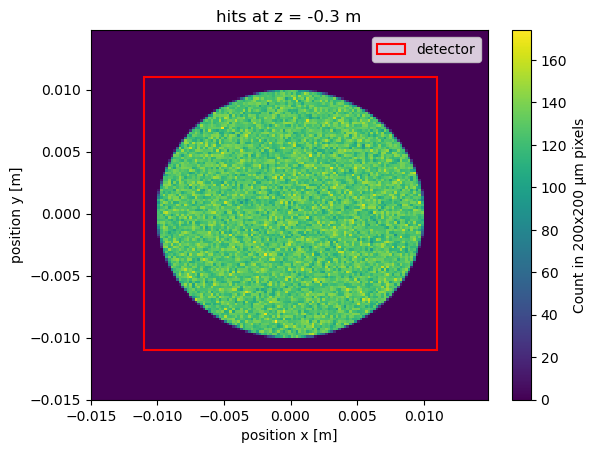

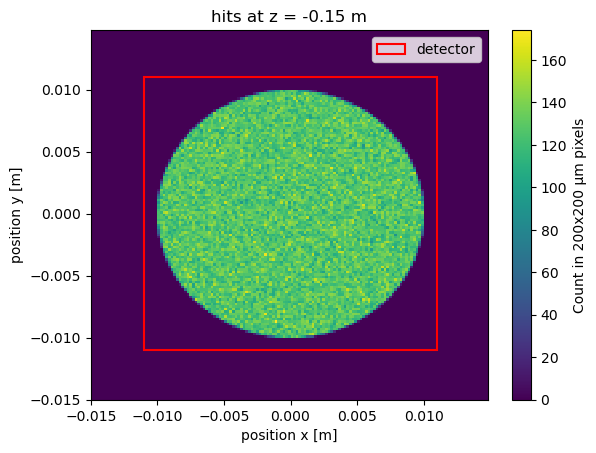

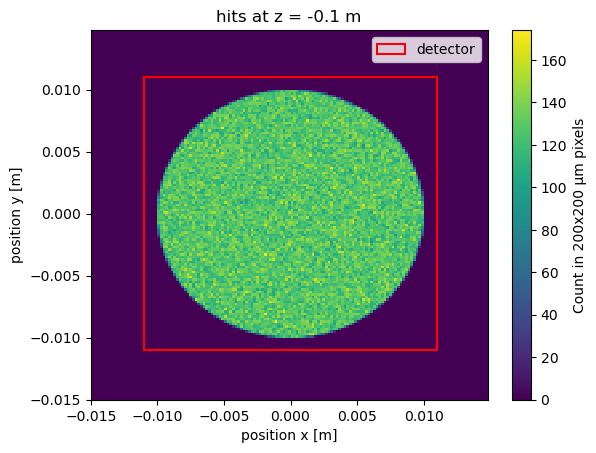

In [12]:
pixel_length = 200e-6 #m
tolerance = 1.05 #%
print("Assuming square pixels of size {}x{} μm and a tolerance of {} %".format(pixel_length*1e6,pixel_length*1e6, tolerance))
for z_pos, data in  r_upstream_positions.items():
    # create hits map 
    x_center, y_center, z_center, x_length, y_length, pixel_length = choose_detector_specs(data,tolerance,pixel_length)
    detector = Detector(x_center, y_center,z_center,x_length, y_length, pixel_length)
    detector.load_data(data)
    positron_detectors[z_pos]=detector

    #plot hits_map
    # here I draw the histogram already using the hit data as if it were a detector, I don't use the simulation directly
    df_positions = detector.get_positions()
    fig, ax = plt.subplots(1,1)
    hist = ax.hist2d(df_positions["x"],df_positions["y"],bins=get_edges(pixel_length, x_center, y_center, x_length, y_length), cmap = "viridis")
    cbar = fig.colorbar(hist[3], ax=ax, cmap="viridis")
    pixel_length_label = round(pixel_length*1e6)
    cbar.set_label('Count in {}x{} μm pixels'.format(pixel_length_label,pixel_length_label))
    ax.set_xlabel("position x [m]")
    ax.set_ylabel("position y [m]")
    ax.set_title("hits at z = {} m".format(data["z"][0]))
    place_detector_on_hitsmap(ax, x_center, y_center, x_length, y_length)

### Comments on positrons

## Analysis for muons before magnetic field

### Code

In [13]:
z_downstream_muons_detectors = np.array([3, 5, 7 ]) # z position of muons detectors before magnetic field

r_downstream__muons_positions = {} # positions of muons according to the simulation
upstream_muons_detectors = {} # detectors for muons
for z_new in z_downstream_muons_detectors:
    R_mu_tmp = propagate_particles(R_scattering,P_mu,z_new,muon_mass)
    R_anti_mu_tmp = propagate_particles(R_scattering,P_anti_mu,z_new,muon_mass)
    data_tmp = {"n": R_mu_tmp.copy(), "p": R_anti_mu_tmp.copy()}
    r_downstream__muons_positions[z_new]=data_tmp

Assuming square pixels of size 50.0x50.0 μm and a tolerance of 1.05 %:

for detector at z=3.0 m we choose:
 - length of 0.0325 m along x and 0.0327 m along y
 - center in (0.0, -0.0) m 
 - with square pixels of size 50.0x50.0 μm the detector is a matrix of 650x654 pixels
 ATTENTION: in this case only 0.0022% of the pairs are at a distance smaller than the pixel size

for detector at z=5.0 m we choose:
 - length of 0.0396 m along x and 0.0401 m along y
 - center in (0.0001, -0.0) m 
 - with square pixels of size 50.0x50.0 μm the detector is a matrix of 792x802 pixels
 ATTENTION: in this case only 0.0013% of the pairs are at a distance smaller than the pixel size

for detector at z=7.0 m we choose:
 - length of 0.0468 m along x and 0.0476 m along y
 - center in (0.0001, 0.0) m 
 - with square pixels of size 50.0x50.0 μm the detector is a matrix of 936x952 pixels
 ATTENTION: in this case only 0.0009% of the pairs are at a distance smaller than the pixel size


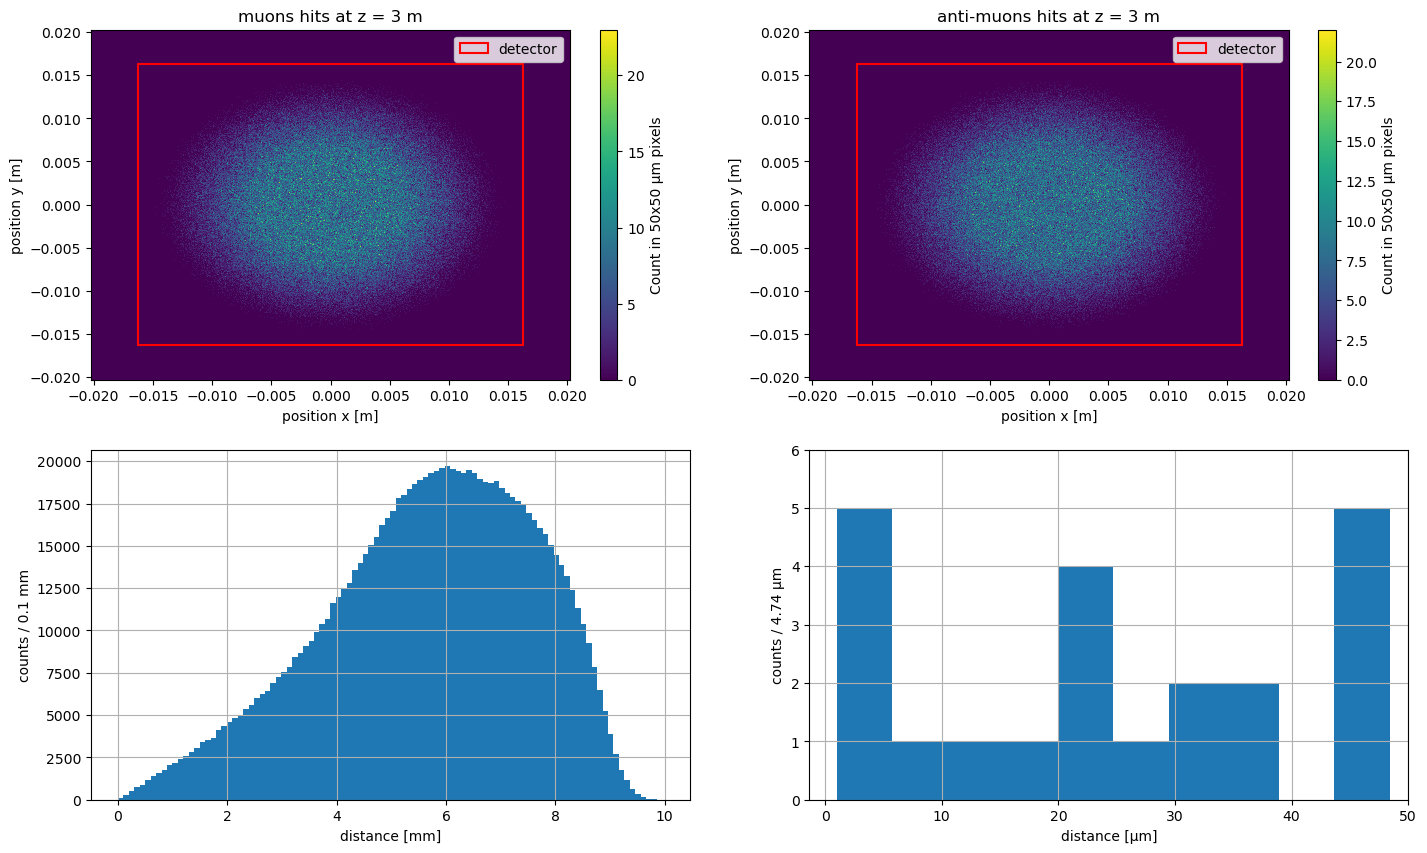

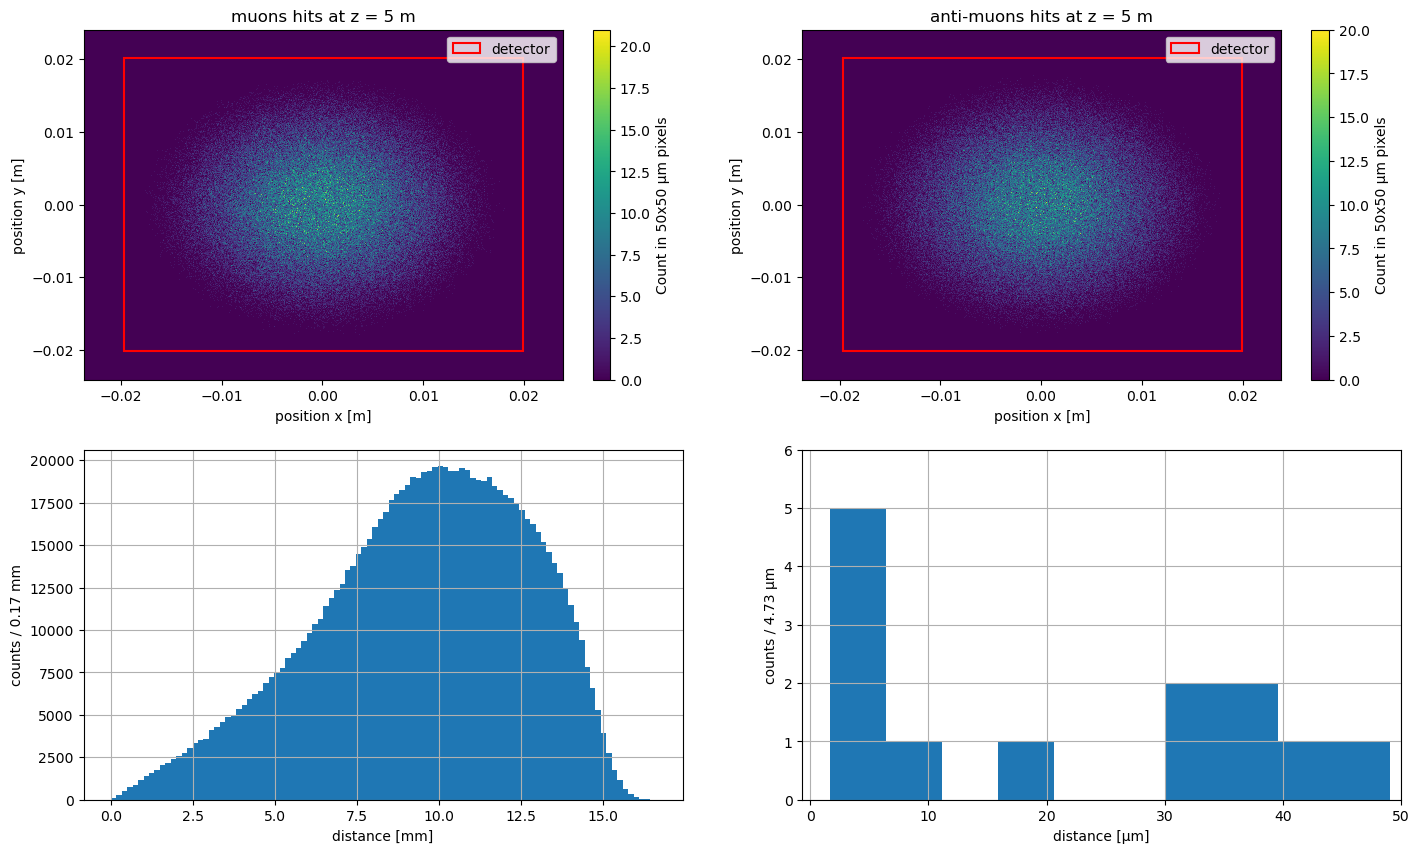

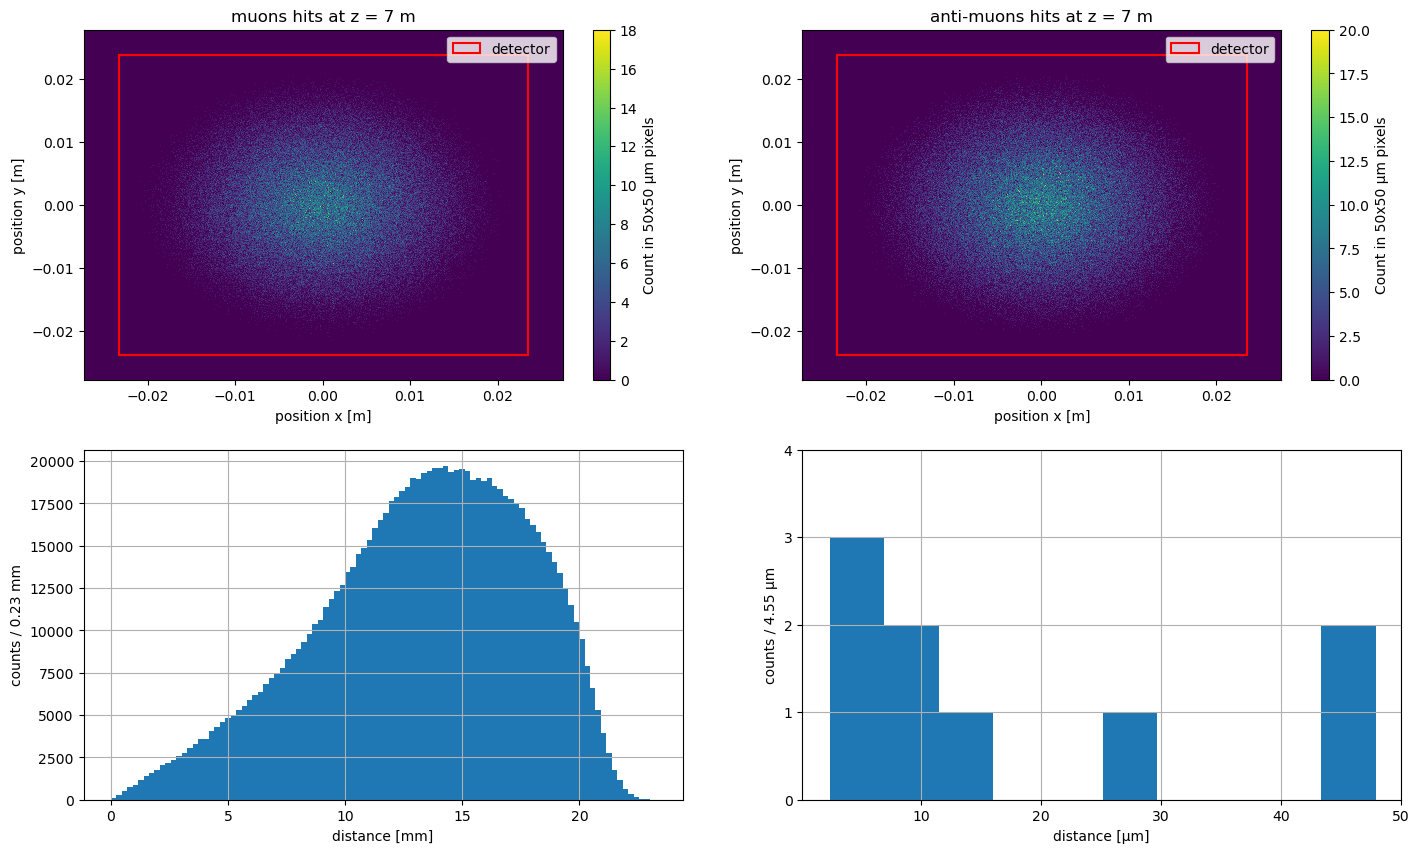

In [14]:
pixel_length = 50e-6 #m
tolerance = 1.05 #%
print("Assuming square pixels of size {}x{} μm and a tolerance of {} %:".format(pixel_length*1e6,pixel_length*1e6, tolerance))

for z_new, data_dic in  r_downstream__muons_positions.items():
    # create hits map
    total_dataset = pd.concat(data_dic.values(),ignore_index=True)
    x_center, y_center, z_center, x_length, y_length, pixel_length = choose_detector_specs(total_dataset,tolerance,pixel_length)
    edges = get_edges(pixel_length, x_center, y_center, x_length, y_length, 80)

    detector_tmp = Detector(x_center, y_center, z_center, x_length, y_length, pixel_length)
    detector_tmp.load_data(data_dic["p"],"p")
    detector_tmp.load_data(data_dic["n"],"n")

    upstream_muons_detectors[z_new]=detector_tmp

    #plot hits maps
    df_positions_p = detector_tmp.get_positions("p")
    df_positions_n = detector_tmp.get_positions("n")
    fig, ax = plt.subplots(2,2, figsize = (17,10) )
    hist_muons_p = ax[0,0].hist2d(df_positions_p["x"],df_positions_p["y"],bins=edges, cmap = "viridis")
    hist_muons_n = ax[0,1].hist2d(df_positions_n["x"],df_positions_n["y"],bins=edges, cmap = "viridis")
 
    histograms_2d = [hist_muons_n, hist_muons_p]
    labels = ["muons", "anti-muons"]

    for a, hist, label in zip(ax[0],histograms_2d, labels):
        cbar = fig.colorbar(hist[3], ax=a, cmap="viridis")
        pixel_length_label = round(pixel_length*1e6)
        cbar.set_label('Count in {}x{} μm pixels'.format(pixel_length_label,pixel_length_label))
        a.set_xlabel("position x [m]")
        a.set_ylabel("position y [m]")
        a.set_title("{} hits at z = {} m".format(label, z_new))
        place_detector_on_hitsmap(a, x_center, y_center, x_length, y_length)

    
    #plot 1d histogram with separation between pairs distribution
    df_dist = (data_dic["p"]-data_dic["n"]) # distance between pairs
    abs_dist = np.sqrt(df_dist["x"]**2 + df_dist["y"]**2 ) # distance in m
    abs_dist_small = abs_dist[abs_dist < pixel_length]     # select events with distance between muons < pixel_length

    abs_dist=abs_dist*1e3                # conversion from m --> mm to make the graph easier to read
    abs_dist_small=abs_dist_small*1e6    # conversion from m --> μm to make the graph easier to read
    
    hist_dist = ax[1,0].hist(abs_dist,bins=100)
    hist_dist_lost = ax[1,1].hist(abs_dist_small,bins=10)
    ax[1,1].set_xlim(right = pixel_length*1e6)
    ax[1,1].set_yticks(range( int(hist_dist_lost[0].max())+2))

    ax[1,0].set_xlabel("distance [mm]")
    ax[1,1].set_xlabel("distance [μm]")
    
    ax[1,0].grid(True)
    ax[1,1].grid(True)

    ax[1,0].set_ylabel("counts / {} mm".format(round(hist_dist[1][1]-hist_dist[1][0],2)))
    ax[1,1].set_ylabel("counts / {} μm".format(round(hist_dist_lost[1][1]-hist_dist_lost[1][0],2)))

    fraction_pair_lost = round(np.sum(hist_dist_lost[0])*100/np.sum(hist_dist[0]),6)
    print(" ATTENTION: in this case only {}% of the pairs are at a distance smaller than the pixel size".format(fraction_pair_lost))    
    

## Propagation of the muons and antimuons in the magnetic field

### Helper functions for this subsection


In [188]:
def propagate_particles_in_B(R_enter,P,charge_sign,B,L):

    # find center of the circumference
    m = P["x"]/P["z"]
    R = np.sqrt(P["x"]**2+P["z"]**2) * 1e9 / (c * B)
    z_tmp = np.sign(m*charge_sign)*R/np.sqrt(1+m**-2)
    x_tmp = -z_tmp/m
    z_center = R_enter["z"] + z_tmp
    x_center = R_enter["x"] + x_tmp

    # find exit point
    z_exit = R_enter["z"]+L
    x_exit = x_center + np.sign(charge_sign) * np.sqrt(R**2 - (z_exit-z_center)**2)
   
    
    # lunghezza corda e arco di circonferenza
    r_length = np.sqrt((R_enter["z"]-z_exit)**2 + (R_enter["x"]-x_exit)**2)
    theta = 2*np.arcsin(r_length/(2*R))
    l_length = R*theta

    # compute y_exit
    p_xz = np.sqrt(P["x"]**2 + P["z"]**2)
    v_xz = p_xz * 1e9 * e/ (c * muon_mass) 
    time = l_length / v_xz
    v_y = P["y"]*1e9*e/(c*muon_mass)
    y_exit = R_enter["y"]+v_y * time

    # create final dataframe for positions
    R_exit = pd.DataFrame({"x":x_exit,"y":y_exit,"z":z_exit})

    # computer particles momentum after a rotation
    pz_exit = P["z"]*np.cos(theta) + P["x"]*np.sign(charge_sign)*np.sin(theta)
    px_exit = -P["z"]*np.sign(charge_sign)*np.sin(theta) + P["x"]*np.cos(theta)

    P_exit = pd.DataFrame({"x":px_exit, "y":P["y"].values, "z":pz_exit})
    
    print(p_xz.loc[0],z_center.loc[0],x_center.loc[0],R.loc[0],x_exit.loc[0],z_exit.loc[0])
    
    return R_exit, P_exit

In [173]:
def propagate_muons_in_Bfield(R_entrance, p_entrance, z_exit, m, B):
    # this function propagates the muons in the magnetic field taking as input the entrance coordinates,
    # the entrance momentum, the z exit coordinate, the muon mass and the magnetic field.
    # it returns the exit coordinates from the magnetic field and the rotation angle

    # modulus of the velocity component on the xz plane
    p_perp = np.sqrt(p_entrance["x"]**2 + p_entrance["z"]**2)
     # radius of the arc of circumference described by the particle
    R = p_perp*1e9/(c*B)

    # coordinates for the centre of the circumference
    # the different sign is due to the different curvature for muons and antimuons in the magnetic field due to their charge
    # and for the sign of the component of the momentum along the x axis for the case of the z coordinate
    x_centre = R_entrance["x"] + R*p_entrance["z"]/p_perp
    z_centre = R_entrance["z"] - R*p_entrance["x"]/p_perp

    # new coordinates after the propagation in the magnetic field.
    # This part is mainly used to get the exit coordinates for x and z
    z_new = np.ones(len(R))*z_exit
    x_new = x_centre - np.sqrt(R**2 - (z_new-z_centre)**2)
    print(p_perp.loc[0],z_centre.loc[0],x_centre.loc[0],R.loc[0],x_new.loc[0],z_new[0])
    # rotation angle
    chord = np.sqrt( (z_new-R_entrance["z"])**2 + (x_new-R_entrance["x"])**2 )
    theta = 2*np.sin(chord/(2*R))
    arc = theta*R
    y_new = R_entrance["y"] + arc*p_entrance["y"]/p_perp

    # DataFrame containing the three components of the exit point 
    r_new = pd.DataFrame({"x": x_new, "y": y_new, "z": z_new})
    
    return r_new, theta


def propagate_antimuons_in_Bfield(R_entrance, p_entrance, z_exit, m, B):
    # in order to avoid cases, the two functions to propagate muons and antimuons are kept separated
    # modulus of the velocity component on the xz plane
    p_perp = np.sqrt(p_entrance["x"]**2 + p_entrance["z"]**2)
    # radius of the arc of circumference described by the particle
    R = p_perp*1e9/(c*B)

    # coordinates for the centre of the circumference
    # the different sign is due to the different curvature for muons and antimuons in the magnetic field due to their charge
    # and for the sign of the component of the momentum along the x axis for the case of the z coordinate
    x_centre = R_entrance["x"] - R*p_entrance["z"]/p_perp  # different sign here for antimuons
    z_centre = R_entrance["z"] + R*p_entrance["x"]/p_perp
    z_new = np.ones(len(R))*z_exit
    x_new = x_centre + np.sqrt(R**2 - (z_new-z_centre)**2)
    print(p_perp.loc[0],z_centre.loc[0],x_centre.loc[0],R.loc[0],x_new.loc[0],z_new[0])
    chord = np.sqrt( (z_new-R_entrance["z"])**2 + (x_new-R_entrance["x"])**2 )
    
    # rotation angle
    theta = 2*np.arcsin(chord/(2*R))
    arc = theta*R
    y_new = R_entrance["y"] + arc*p_entrance["y"]/p_perp
    r_new = pd.DataFrame({"x": x_new, "y": y_new, "z": z_new})
    
    return r_new, theta


def propagate_mu_momenta(p_entrance, rot_angle):
    # this function propagates the muon/antimuon momenta at the end of the magnetic field 
    # the zx components are rotated according to the rotation angle
    # while the y component is kept since it is not modified by the motion in the magnetic field region
    px_new = p_entrance["z"]*np.sin(rot_angle)+p_entrance["x"]*np.cos(rot_angle)
    py_new = p_entrance["y"]
    pz_new = p_entrance["z"]*np.cos(rot_angle)-p_entrance["x"]*np.sin(rot_angle)
    p_new = pd.DataFrame({"x": px_new, "y": py_new, "z": pz_new})
    
    return p_new


def propagate_antimu_momenta(p_entrance, rot_angle):
    # this function is the analogous of the previous one for the case of antimuons.
    # Since the two DataFrames for muons and antimuons are analyzed separately it is simpler
    # and the code is clearer if two distinct functions are used to rotate the particles'momentum components
    px_new = -p_entrance["z"]*np.sin(rot_angle)+p_entrance["x"]*np.cos(rot_angle)
    py_new = p_entrance["y"]
    pz_new = p_entrance["z"]*np.cos(rot_angle)+p_entrance["x"]*np.sin(rot_angle)
    p_new = pd.DataFrame({"x": px_new, "y": py_new, "z": pz_new})
    
    return p_new

### Code

In [189]:
# propagation of the particles until the beginning of the magnetic field
# coordinates at the entrance position of the magnetic field
R_mu_entrance = propagate_particles(R_scattering, P_mu, z_mag, muon_mass)
R_anti_mu_entrance = propagate_particles(R_scattering, P_anti_mu, z_mag, muon_mass)

#### Quick check

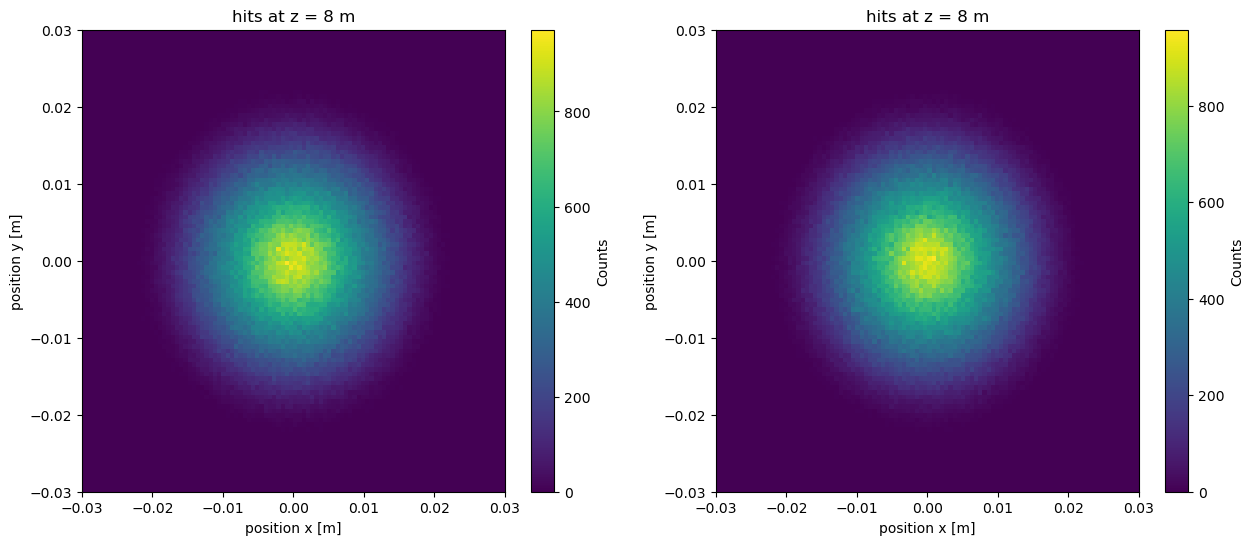

In [190]:
# this part is just to have a quick visual idea of the position of the μ at the beginning of the B field region
# it can be deleted later
fig, ax = plt.subplots(1, 2, figsize=(15,6))
hist0 = ax[0].hist2d(R_mu_entrance["x"], R_mu_entrance["y"], bins=(100,100), range=[[-0.03,0.03],[-0.03,0.03]], cmap = "viridis")
colorbar = fig.colorbar(hist0[3], ax=ax[0], cmap="viridis")
colorbar.set_label('Counts')
ax[0].set_xlabel("position x [m]")
ax[0].set_ylabel("position y [m]")
ax[0].set_title("hits at z = {} m".format(z_mag))

hist1 = ax[1].hist2d(R_anti_mu_entrance["x"], R_anti_mu_entrance["y"], bins=(100,100), range=[[-0.03,0.03],[-0.03,0.03]], cmap = "viridis")
colorbar = fig.colorbar(hist1[3], ax=ax[1], cmap="viridis")
colorbar.set_label('Counts')
ax[1].set_xlabel("position x [m]")
ax[1].set_ylabel("position y [m]")
ax[1].set_title("hits at z = {} m".format(z_mag))
plt.show()

### Code

In [191]:
# propagation of the muons and antimuons in the magnetic field
z_exit = L+z_mag # m
#R_mu_exitB, theta_mu = propagate_muons_in_Bfield(R_mu_entrance, P_mu, z_exit, muon_mass, B)
#R_anti_mu_exitB, theta_antimu = propagate_antimuons_in_Bfield(R_anti_mu_entrance, P_anti_mu, z_exit, muon_mass, B)
R_mu_exitB, P_mu_afterB = propagate_particles_in_B(R_mu_entrance, P_mu, -1, B, L)
R_anti_mu_exitB, P_anti_mu_afterB = propagate_particles_in_B(R_anti_mu_entrance, P_anti_mu, 1, B, L)
#P_anti_mu_afterB

27.366912510712464 7.9486548712544955 53.712073226753844 53.69776123531054 0.05350872072935431 10.0
20.2281169259274 7.948654871254495 -39.694030800734225 39.6904324703494 -0.05664424654604261 10.0


#### Quick check

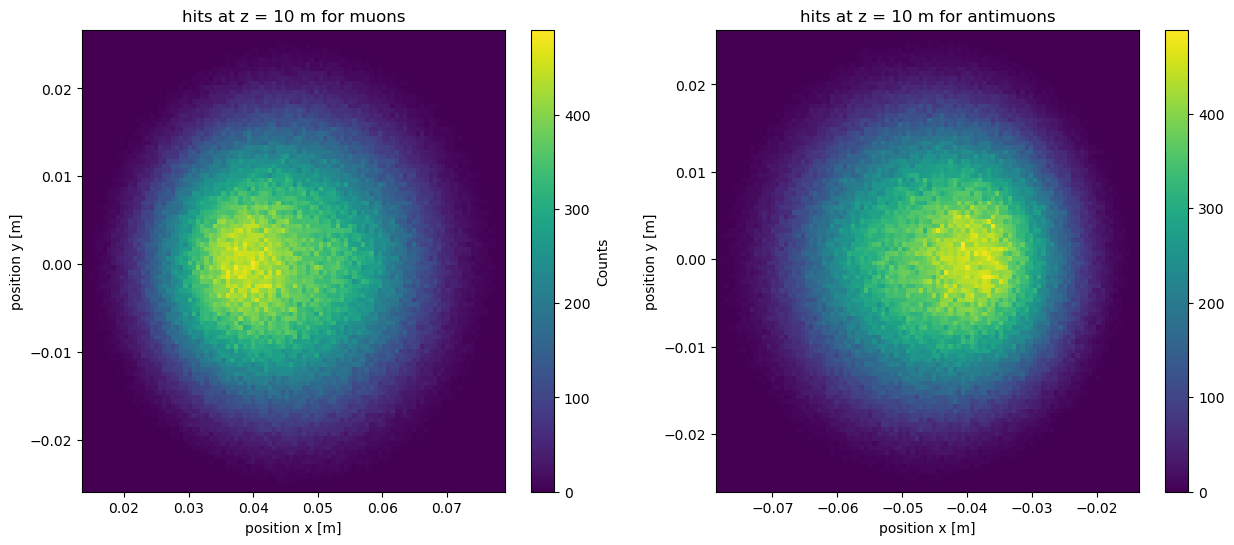

In [192]:
# plot to check the muons location at the exit of the magnetic field
# it can be deleted later
fig, ax = plt.subplots(1, 2, figsize=(15,6))
hist0 = ax[0].hist2d(R_mu_exitB["x"], R_mu_exitB["y"], bins=(100,100), cmap = "viridis")
colorbar = fig.colorbar(hist0[3], ax=ax[0], cmap="viridis")
colorbar.set_label('Counts')
ax[0].set_xlabel("position x [m]")
ax[0].set_ylabel("position y [m]")
ax[0].set_title("hits at z = {} m for muons".format(z_exit))

hist1 = ax[1].hist2d(R_anti_mu_exitB["x"], R_anti_mu_exitB["y"], bins=(100,100), cmap = "viridis")
cbar = fig.colorbar(hist1[3], ax=ax[1], cmap="viridis")
# cbar.set_label('Count in {}x{} μm pixels'.format(pixel_length_label,pixel_length_label))
ax[1].set_xlabel("position x [m]")
ax[1].set_ylabel("position y [m]")
ax[1].set_title("hits at z = {} m for antimuons".format(z_exit))

plt.show()

### Code

In [193]:
# propagation of the muons and antimuons momenta in the magnetic field
#P_mu_afterB = propagate_mu_momenta(P_mu, theta_mu)
#P_anti_mu_afterB = propagate_antimu_momenta(P_anti_mu, theta_antimu)
print(P_mu, P_mu_afterB)

               x         y        z
0       0.026168  0.005782  27.3669
1       0.029397 -0.004837  19.3068
2       0.001136 -0.023830  28.3075
3      -0.002160 -0.011196  17.4952
4       0.031203  0.005236  21.6927
...          ...       ...      ...
999909  0.013418  0.010555  26.1718
999910  0.003372  0.019434  25.1396
999911  0.009716  0.008148  21.7877
999912 -0.017934  0.020388  19.8603
999913 -0.016819  0.025257  21.9434

[999914 rows x 3 columns]                x         y          z
0       1.045462  0.005782  27.346936
1       1.048691 -0.004837  19.278320
2       1.020431 -0.023830  28.289102
3       1.017134 -0.011196  17.465608
4       1.050497  0.005236  21.667272
...          ...       ...        ...
999909  1.032713  0.010555  26.151421
999910  1.022667  0.019434  25.118791
999911  1.029010  0.008148  21.763389
999912  1.001360  0.020388  19.835048
999913  1.002475  0.025257  21.920496

[999914 rows x 3 columns]


In [194]:
print(P_anti_mu,P_anti_mu_afterB)

               x         y        z
0      -0.026168 -0.005782  20.2281
1      -0.029397  0.004837  30.3273
2      -0.001136  0.023830  19.3267
3       0.002160  0.011196  30.0357
4      -0.031203 -0.005236  26.3991
...          ...       ...      ...
999909 -0.013418 -0.010555  19.6198
999910 -0.003372 -0.019434  20.5562
999911 -0.009716 -0.008148  22.5688
999912  0.017934 -0.020388  28.1794
999913  0.016819 -0.025257  25.6649

[999914 rows x 3 columns]                x         y          z
0      -1.045462 -0.005782  20.201082
1      -1.048691  0.004837  30.309177
2      -1.020431  0.023830  19.299742
3      -1.017134  0.011196  30.018473
4      -1.050497 -0.005236  26.378209
...          ...       ...        ...
999909 -1.032713 -0.010555  19.592607
999910 -1.022667 -0.019434  20.530746
999911 -1.029010 -0.008148  22.545331
999912 -1.001360 -0.020388  28.161608
999913 -1.002475 -0.025257  25.645320

[999914 rows x 3 columns]


#### Quick check

In [195]:
# check for an arbitrary position 
z_exit = 13. # m

R_mu_tmp = propagate_particles(R_mu_exitB, P_mu_afterB, z_exit, muon_mass)
R_anti_mu_tmp = propagate_particles(R_anti_mu_exitB, P_anti_mu_afterB, z_exit, muon_mass)

Text(0, 0.5, 'position y [m]')

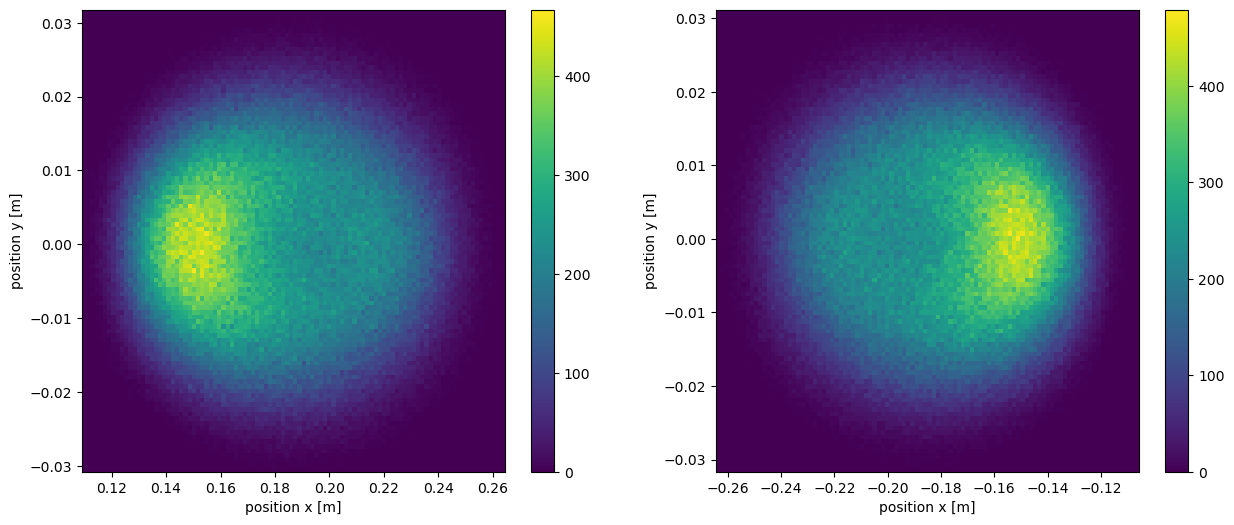

In [196]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
hist0 = ax[0].hist2d(R_mu_tmp["x"], R_mu_tmp["y"], bins=(100,100), cmap = "viridis")
cbar = fig.colorbar(hist0[3], ax=ax[0], cmap="viridis")
# cbar.set_label('Count in {}x{} μm pixels'.format(pixel_length_label,pixel_length_label))
ax[0].set_xlabel("position x [m]")
ax[0].set_ylabel("position y [m]")
# ax.set_title("hits at z = {} m".format(data["z"][0]))

hist1 = ax[1].hist2d(R_anti_mu_tmp["x"], R_anti_mu_tmp["y"], bins=(100,100), cmap = "viridis")
cbar = fig.colorbar(hist1[3], ax=ax[1], cmap="viridis")
# cbar.set_label('Count in {}x{} μm pixels'.format(pixel_length_label,pixel_length_label))
ax[1].set_xlabel("position x [m]")
ax[1].set_ylabel("position y [m]")

### Code

In [197]:
z_afterB_muons_detectors = np.array([12., 14., 16.]) # z of the silicon trackers after the magnetic field

r_afterB__muons_positions = {}
afterB_muons_detectors = {}
for z_new in z_afterB_muons_detectors:
    R_mu_tmp = propagate_particles(R_mu_exitB, P_mu_afterB, z_new, muon_mass)
    R_anti_mu_tmp = propagate_particles(R_anti_mu_exitB, P_anti_mu_afterB, z_new, muon_mass)
    data_tmp = {"mu": R_mu_tmp.copy(), "antimu": R_anti_mu_tmp.copy()}
    r_afterB__muons_positions[z_new] = data_tmp

Assuming square pixels of size 50.0x50.0 μm and a tolerance of 1.05 %:

for detector at z=12.0 m we choose:
 - length of 0.1356 m along x and 0.0652 m along y
 - center in (0.147, 0.0005) m 
 - with square pixels of size 50.0x50.0 μm the detector is a matrix of 2712x1304 pixels

for detector at z=12.0 m we choose:
 - length of 0.1382 m along x and 0.0655 m along y
 - center in (-0.1458, -0.0002) m 
 - with square pixels of size 50.0x50.0 μm the detector is a matrix of 2764x1310 pixels

for detector at z=14.0 m we choose:
 - length of 0.2076 m along x and 0.0726 m along y
 - center in (0.2448, 0.0005) m 
 - with square pixels of size 50.0x50.0 μm the detector is a matrix of 4152x1452 pixels

for detector at z=14.0 m we choose:
 - length of 0.2115 m along x and 0.0728 m along y
 - center in (-0.2429, -0.0003) m 
 - with square pixels of size 50.0x50.0 μm the detector is a matrix of 4230x1456 pixels

for detector at z=16.0 m we choose:
 - length of 0.2808 m along x and 0.08 m along y
 - c

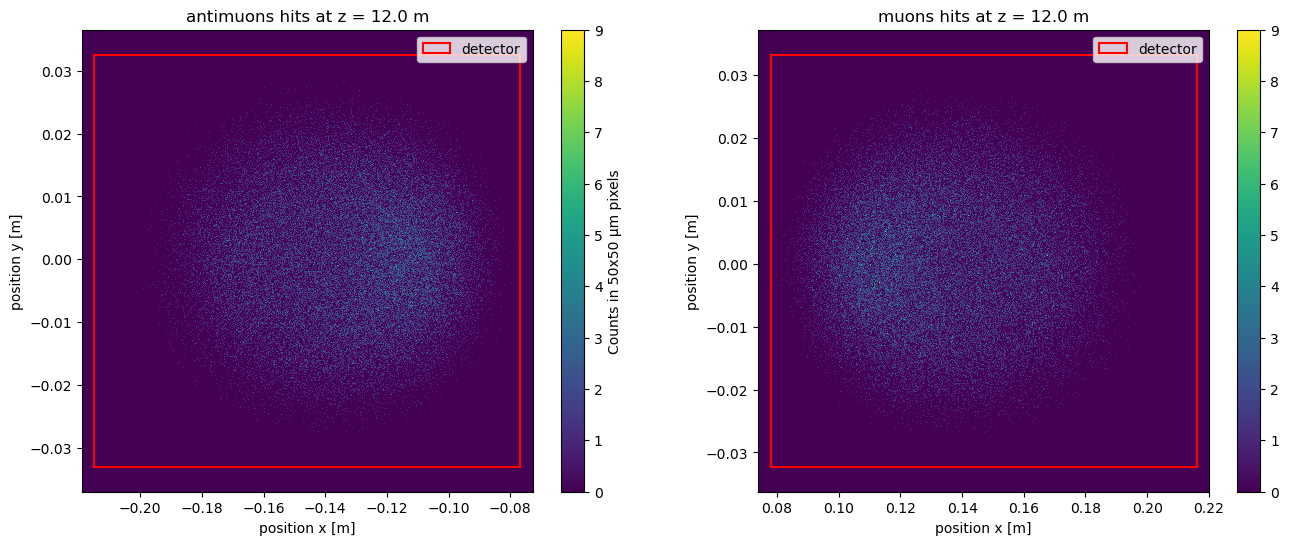

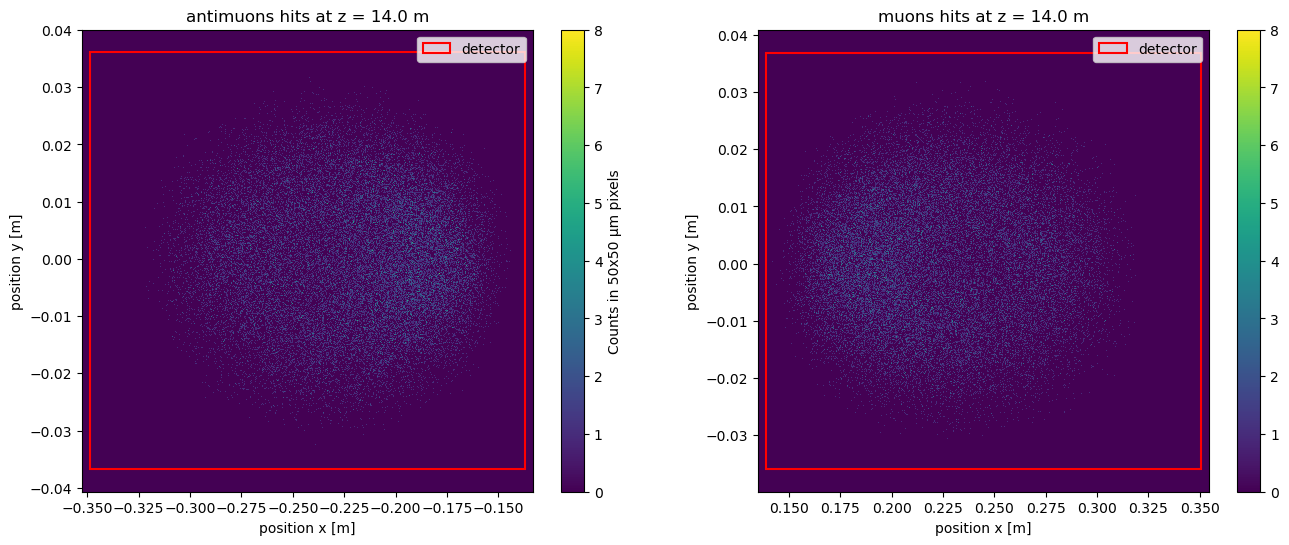

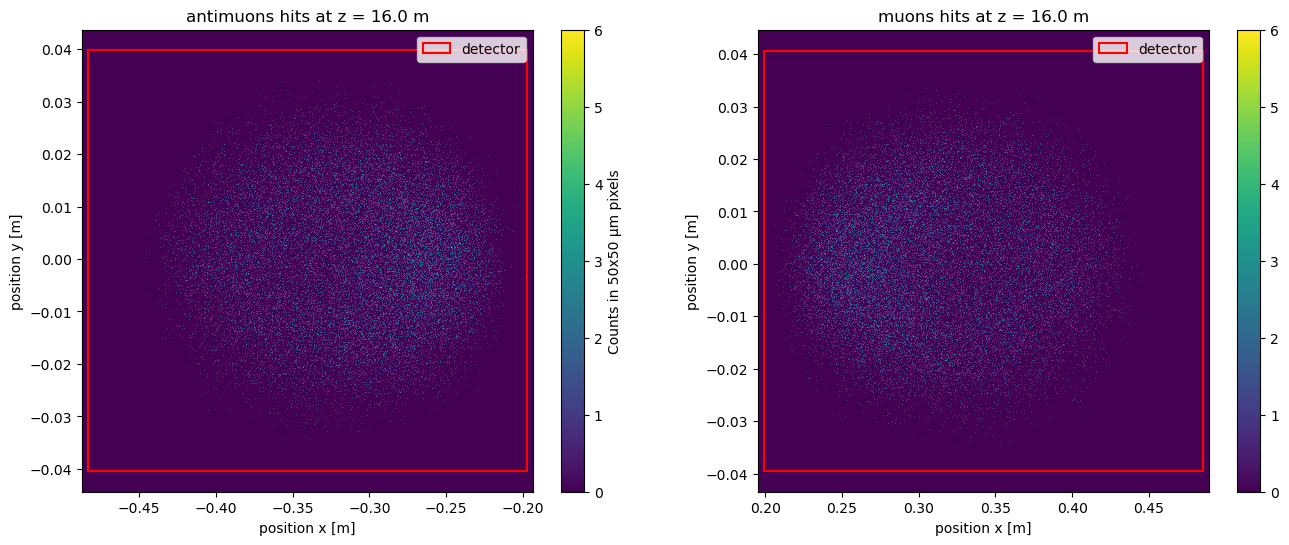

In [198]:
pixel_length = 50e-6 #m
tolerance = 1.05 #%
print("Assuming square pixels of size {}x{} μm and a tolerance of {} %:".format(pixel_length*1e6, pixel_length*1e6, tolerance))

for z_new, data in  r_afterB__muons_positions.items():
    # create hits map
    x_center_mu, y_center_mu, z_center_mu, x_length_mu, y_length_mu, pixel_length_mu = choose_detector_specs(data["mu"], tolerance, pixel_length)
    x_center_antimu, y_center_antimu, z_center_antimu, x_length_antimu, y_length_antimu, pixel_length_antimu = choose_detector_specs(data["antimu"], tolerance, pixel_length)

    x_length = max(x_length_mu, x_length_antimu)
    y_length = max(y_length_mu, y_length_antimu)
    
    edges_mu = get_edges(pixel_length_mu, x_center_mu, y_center_mu, x_length, y_length, 80)
    edges_antimu = get_edges(pixel_length_antimu, x_center_antimu, y_center_antimu, x_length, y_length, 80)

    detector_mu_tmp = Detector(x_center_mu, y_center_mu, z_center_mu, x_length, y_length, pixel_length)
    detector_mu_tmp.load_data(data["mu"])
    detector_antimu_tmp = Detector(x_center_antimu, y_center_antimu, z_center_antimu, x_length, y_length, pixel_length)
    detector_antimu_tmp.load_data(data["antimu"])
    
    detector_tmp = {
                    "mu": detector_mu_tmp,
                    "antimu": detector_antimu_tmp
                   }
    afterB_muons_detectors[z_new]=detector_tmp

    #plot hits maps
    df_positions_mu = detector_tmp["mu"].get_positions()
    df_positions_antimu = detector_tmp["antimu"].get_positions()
    fig, ax = plt.subplots(1, 2, figsize = (16, 6) )
    hist_muons = ax[1].hist2d(df_positions_mu["x"],df_positions_mu["y"], bins=edges_mu, cmap = "viridis")
    hist_antimuons = ax[0].hist2d(df_positions_antimu["x"], df_positions_antimu["y"], bins=edges_antimu, cmap = "viridis")

    colorbar = fig.colorbar(hist_muons[3], ax=ax[1], cmap="viridis")
    colorbar = fig.colorbar(hist_antimuons[3], ax=ax[0], cmap="viridis")
    pixel_length_label = round(pixel_length*1e6)
    colorbar.set_label('Counts in {}x{} μm pixels'.format(pixel_length_label, pixel_length_label))
    labels = ["antimuons", "muons"]
    for a, lab in zip(ax, labels):
        a.set_xlabel("position x [m]")
        a.set_ylabel("position y [m]")
        a.set_title("{} hits at z = {} m".format(lab, z_new))
    place_detector_on_hitsmap(ax[1], x_center_mu, y_center_mu, x_length, y_length)
    place_detector_on_hitsmap(ax[0], x_center_antimu, y_center_antimu, x_length, y_length)

## Noise generation

### Helper functions

In [199]:
def extract_objects_from_dict(input_dict,label = ""):
    # this function is used to quickly retrieve muon and antimuon detectors from a dictionary
    
    output_dict = {}
    for key, value in input_dict.items():
        output_dict[key] = value[label]
    return output_dict

### Code

In [200]:
poisson_expected_value = 1
all_detectors = [
                  positron_detectors, 
                  upstream_muons_detectors, 
                  extract_objects_from_dict(afterB_muons_detectors,"mu"),
                  extract_objects_from_dict(afterB_muons_detectors,"antimu")
                ]

start_time = time.time()

for detector_dict in all_detectors:
    for det in detector_dict.values():
        det.generate_poisson_noise(poisson_expected_value)

for position in  afterB_muons_detectors:
   for particle_det in afterB_muons_detectors[position].values():
       particle_det.generate_poisson_noise(poisson_expected_value)

end_time = time.time()
print("Time to generate noise: {} s".format(end_time - start_time))

Time to generate noise: 17.488513708114624 s


# Tracking

### helper functions

In [201]:
def get_possible_tracks(event_list, monotonic = True):
    # since the detectors are placed in the absence of a magnetic field, the traces can only be straight and monotonic 
    # traces (both increasing and decreasing) along all axes. Therefore, also considering the noise, 
    # I create all the possible tracks in the detectors, then select only those that are monotonous
    
    triplets = np.array(list(product(*event_list)))
    # Seleziona le triplette con valori crescenti o decrescenti su x e y
    selected_triplets = []
    
    if not monotonic:
        return triplets
        
    for triplet in triplets:
        x_values = np.array([np.round(triplet[i][0],14) for i in range(len(event_list))])
        y_values = np.array([np.round(triplet[i][1],14) for i in range(len(event_list))])
        
        # Verifica se le x e y sono in ordine crescente o decrescente
        if np.all(np.diff(x_values) >= 0) or np.all(np.diff(x_values) <= 0):
            if np.all(np.diff(y_values) >= 0) or np.all(np.diff(y_values) <= 0):
                selected_triplets.append(np.array(triplet))
    return np.array(selected_triplets)

In [202]:
def get_pixel_lists(detector_dic, trigger_number):
    # I take the list of pixels lit at a certain trigger number from all the detectors in question
    return [ det.get_trigger(trigger_number) for det in detector_dic.values()]

In [203]:
def get_straight_traces(traces):
    # I select all the tracks that go straight, since the positrons go perfectly straight
    count = 0
    straight_trace =[]
    for trace in traces:
        if (np.sum(trace[0][0] == trace[:,0]) == trace[:,0].shape[0]):
            if (np.sum(trace[0][1] == trace[:,1]) == trace[:,1].shape[0]):
                count = count + 1
                straight_trace.append(trace)
    straight_trace = np.array(straight_trace)
    if count == 1:
        return straight_trace[0]
    elif count > 1:
        print("ERROR: more than one straight track, positron lost, choosing randomly")
        n_straight_tracks = straight_trace.shape[0]
        indexes = np.arange(n_straight_tracks)
        random_index = np.random.choice(indexes)
        return straight_trace[random_index]
    elif count == 0:
        print("ERROR: positron not detected properly, no straight track found")
        return

In [204]:
def fit_line_3d(matrix):
    # using principal component analysis, I select the direction that best describes the points contained in the tracks
    
    matrix_t = matrix.T
    r0 = np.mean(matrix_t,axis=1)
    matrix_t_center = matrix_t - r0.reshape(3,1)

    cov = np.cov(matrix_t_center)
    result = sp.linalg.svd(cov)
    v0 = result[0][:,0]
    accuracy = result[1][0]/np.sum(result[1])
    
    return r0, v0, accuracy

In [205]:
def find_best_track(trace_list, n_traces = 1):
    # according the best fit, here we select choose which is the real track
    # among all the possible combinations
    
    fit_results = []
    fit_accuracies = []
    if len(trace_list.shape) == 2:
        trace_list = trace_list.reshape(1,trace_list.shape[0],trace_list.shape[1])
    for trace in trace_list:
        r0_tmp, v0_tmp, accuracy_tmp = fit_line_3d(trace)
        fit_results.append({"r0":r0_tmp, "v0":v0_tmp})
        fit_accuracies.append(accuracy_tmp)
    
    fit_accuracies = np.array(fit_accuracies)
    sorted_index = np.argsort(fit_accuracies)[::-1]
    if n_traces == 1:
        return [fit_results[sorted_index[0]]], [fit_accuracies[sorted_index[0]]], [trace_list[sorted_index[0]]]
    
    best_traces = trace_list[sorted_index[:n_traces]]
    best_fit_accuracies = fit_accuracies[sorted_index[:n_traces]]
    best_results = [fit_results[i] for i in sorted_index[:n_traces]]
    
    return best_results, best_fit_accuracies, best_traces 

In [206]:
def get_real_track(detector_list,trigger_number,label = "all"):
    # here we get the real track from all the Detectors
    real_pixels = np.array([det.get_real_events(trigger_number, label) for det in detector_list.values()])
    return real_pixels

In [207]:
def plot_3d_line_and_points(ro, v0, points):
    # this function is not part of the analysis. It's just useful
    # to check visually if the fit works 
    
    # ATTENTION: use %matplotlib ipympl when you use the function!
    # linspace parameter
    t = np.linspace(-10, 10, 100)

    # point to plot
    line_points = ro + np.outer(t, v0)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], label='Points')
    ax.plot(line_points[:, 0], line_points[:, 1], line_points[:, 2], label='Line', color='red')

    # set graph
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()

    # show the graph
    plt.show()

In [208]:
def make_tracks_from_detector(detector_dict, trigger_initial=-1, trigger_final=-1, n_expected_tracks=-1, monotonic=True, straight=False):
    # function that uses all of the above in a for loop that loops trigger by trigger, and each time selects the most probable trace. 
    # The important thing is that the result is a dataframe that not only contains the traces obtained from the fit, but also the 
    # variable is_correct, which tells us whether the trace found is actually physical, and the variable real_particle, which tells 
    # us whether the selected trace belong to a muon or anti-muon
    
    # set good values for trigger initial and trigger fine 
    if trigger_initial == -1:
        trigger_initial = 0

    # check for a possible error on detector events dimention
    n_events = np.array([det.n_events for det in detector_dict.values()])
    if np.sum(n_events[0] == n_events) != n_events.shape:
        print("ERROR: in the detector dictionary provided the number of triggers in not the same: n_triggers = ", n_events)
        exit()

    if trigger_final == -1:
        trigger_final = n_events[0]
    elif trigger_final > n_events[0]:
        print("ERROR: trigger_final {} is bigger than n_events {} in the detector!".format(trigger_final,n_events[0]))

    if n_expected_tracks == -1:
        print("ERROR: you must provide the number of tracks you want to obtain from each trigger!")
        return

    # useful quantities for analysis
    z_values = list(detector_dict.keys())
    particles = list(detector_dict[z_values[0]].dataset_dict.keys())

    obtained_r0 = [ [] for i in range(n_expected_tracks)]
    obtained_v0 = [ [] for i in range(n_expected_tracks)]  
    obtained_is_correct = [ [] for i in range(n_expected_tracks)]
    real_label = [ [] for i in range(n_expected_tracks)]
    selected_tracks_list = [ [] for i in range(n_expected_tracks)]
    correct_tracks_list = []
    
    for trigger_number in tqdm(range(trigger_initial, trigger_final,1)):
        activated_pixels_in_each_detector = get_pixel_lists(detector_dict,trigger_number)
        possible_tracks = get_possible_tracks(activated_pixels_in_each_detector, monotonic = monotonic)
        if straight:
            possible_tracks = get_straight_traces(possible_tracks)
        fit_results, fit_accuracies, selected_tracks  = find_best_track(possible_tracks, n_expected_tracks)
        correct_tracks = np.array([get_real_track(detector_dict,trigger_number,label) for label in particles])
        for res, r0_list, v0_list, is_correct_list, track, real_label_list, select_track_l in zip(fit_results,obtained_r0,obtained_v0,obtained_is_correct,selected_tracks,real_label,selected_tracks_list):
            r0_list.append(res["r0"])
            v0_list.append(res["v0"])
            is_correct_list.append(any(np.array_equal(track, matrix) for matrix in correct_tracks))
            select_track_l.append(track)
            
            if n_expected_tracks > 1:
                real_muon_track = get_real_track(detector_dict,trigger_number,"n")
                real_antimuon_track = get_real_track(detector_dict,trigger_number,"p")
                if np.array_equal(track,real_muon_track):
                    real_label_list.append("mu")
                elif np.array_equal(track,real_antimuon_track):
                    real_label_list.append("anti-mu")
                else:
                    real_label_list.append("noise")
        
        correct_tracks_list.append(correct_tracks)



    obtained_r0 = np.array([ np.array(t) for t in obtained_r0 ])
    obtained_v0 = np.array([ np.array(t) for t in obtained_v0 ])
    obtained_is_correct = np.array([ np.array(t) for t in obtained_is_correct ])
    
    tracks_dataframes = []
    for i in range(n_expected_tracks):
        df_tmp = pd.DataFrame({
            'rx': obtained_r0[i][:,0],
            'ry': obtained_r0[i][:,1],
            'rz': obtained_r0[i][:,2],
            'vx': obtained_v0[i][:,0],
            'vy': obtained_v0[i][:,1],
            'vz': obtained_v0[i][:,2],
            'is_correct': obtained_is_correct[i][:]
        }) 

        if n_expected_tracks > 1:
            df_tmp["real_particle"] = real_label[i]

        tracks_dataframes.append(df_tmp)
    
    return tracks_dataframes, selected_tracks_list, correct_tracks_list

In [209]:
def write_list_on_file(file_name, list):
    # function to write a python list on a file
    with open(file_name, 'wb') as file:
        pickle.dump(list, file)
    return


In [210]:
def load_list_from_file(file_name):
    # function to load a python list from a file
    with open(file_name, 'rb') as file:
        loaded_list = pickle.load(file)
    return loaded_list

In [211]:
def create_new_fit_result_folder(folder_name = "fit_results"):
    # function that creates a new folder for the fit results
    
    # Main folder path
    main_path = "./"

    # Full path
    full_path = os.path.join(main_path, folder_name)

    # Get the list of directory names
    directory_names = [name for name in os.listdir(full_path) if os.path.isdir(os.path.join(full_path, name))]
    directory_names = [item for item in directory_names if "." not in item]
    # If directories are present, determine the maximum number
    if directory_names:
        folder_numbers = [int(name) for name in directory_names]
        new_number = max(folder_numbers) + 1
    else:
        # If no directories, start from 1
        new_number = 1

    # Create the new folder
    new_folder = os.path.join(full_path, str(new_number))
    os.makedirs(new_folder)

    return new_folder


In [212]:
def get_more_recent_fit_folder(which_cycle = -1, folder_name = "fit_results"):
    # function that returns a specific folder with the tracks results:
    # if which_cycle == -1 then returns the latest tracks results
    # if which_cycle == integer returns the returns the results of the correspondig tracks
    main_path = "./"

    # Full path
    full_path = os.path.join(main_path, folder_name)

    # Get the list of directory names
    directory_names = [name for name in os.listdir(full_path) if os.path.isdir(os.path.join(full_path, name))]
    directory_names = [item for item in directory_names if "." not in item]
    # If directories are present, determine the maximum number
    if directory_names:
        folder_numbers = [int(name) for name in directory_names]
        if which_cycle == -1:
            return full_path + "/" + str(max(folder_numbers))
        else:
            return full_path + "/" + str(which_cycle)
    else:
        # If no directories, error
        print("ERROR: no fit results detected in folder", full_path)

    return

### Code

In [340]:
#%%script echo cell skipped 
# comment the previous line if you want to execute this cell, it can take a lot of time! up to 1 hour.
# here one by one we track the positrons and the muons, than we write the results in the fit_results folder 

n_events_to_analyze = 20000 # if -1 analyses all dataset
fit_folder = create_new_fit_result_folder()
print("The fit results will be printed in", fit_folder)

#analyze positrons
start_time = time.time()
df_positrons_fit, positrion_selected_tracks, positron_correct_tracks = make_tracks_from_detector(positron_detectors,0,n_events_to_analyze,1,False,True)
df_positrons_fit[0].to_csv(fit_folder + "/df_positrons_fits.csv",index_label='relative_index')
write_list_on_file(fit_folder + "/list_positrons_selected_tracks.pkl",positrion_selected_tracks[0])
write_list_on_file(fit_folder + "/list_positrons_correct_tracks.pkl",positron_correct_tracks)
end_time = time.time()
print("Time for positrons: {} s, for {} events".format(end_time - start_time, n_events_to_analyze))

accuracy = np.sum(df_positrons_fit[0]["is_correct"].values)/df_positrons_fit[0]["is_correct"].values.shape[0]
print("accuracy in tracks identification:",accuracy)

#analyze muons before B

start_time = time.time()
df_upstream_muons_fit, upstream_muons_select_tracks, upstream_muons_correct_tracks = make_tracks_from_detector(upstream_muons_detectors,0,n_events_to_analyze,2,True,False)
df_upstream_muons_fit[0].to_csv(fit_folder + "/df_upstream_muons_0_fits.csv",index_label='relative_index')
df_upstream_muons_fit[1].to_csv(fit_folder + "/df_upstream_muons_1_fits.csv",index_label='relative_index')
write_list_on_file(fit_folder + "/list_upstream_muons_selected_0_tracks.pkl",upstream_muons_select_tracks[0])
write_list_on_file(fit_folder + "/list_upstream_muons_selected_1_tracks.pkl",upstream_muons_select_tracks[1])
write_list_on_file(fit_folder + "/list_upstream_muons_correct_tracks.pkl",upstream_muons_correct_tracks)
end_time = time.time()
print("Time for upstream muons: {} s, for {} events".format(end_time - start_time, n_events_to_analyze))

accuracy = np.sum(df_upstream_muons_fit[0]["is_correct"].values)/df_upstream_muons_fit[0]["is_correct"].values.shape[0]
print("accuracy in tracks identification:",accuracy)
accuracy = np.sum(df_upstream_muons_fit[1]["is_correct"].values)/df_upstream_muons_fit[1]["is_correct"].values.shape[0]
print("accuracy in tracks identification:",accuracy)

#analyze muons after B

start_time = time.time()
df_downstream_muons_fit, downstream_muons_selected_tracks, downstream_muons_correct_tracks = make_tracks_from_detector(extract_objects_from_dict(afterB_muons_detectors,"mu"),0,n_events_to_analyze,1,True,False)
df_downstream_muons_fit[0].to_csv(fit_folder + "/df_downstream_muons_fits.csv",index_label='relative_index')
write_list_on_file(fit_folder + "/list_downstream_muons_selected_tracks.pkl",downstream_muons_selected_tracks[0])
write_list_on_file(fit_folder + "/list_downstream_muons_correct_tracks.pkl",downstream_muons_correct_tracks)
end_time = time.time()
print("Time for downstream muons: {} s, for {} events".format(end_time - start_time, n_events_to_analyze))

accuracy = np.sum(df_downstream_muons_fit[0]["is_correct"].values)/df_downstream_muons_fit[0]["is_correct"].values.shape[0]
print("accuracy in tracks identification downstream muons:",accuracy)

start_time = time.time()
df_downstream_antimuons_fit, downstream_antimuons_selected_tracks, downstream_antimuons_correct_tracks = make_tracks_from_detector(extract_objects_from_dict(afterB_muons_detectors,"antimu"),0,n_events_to_analyze,1,True,False)
df_downstream_antimuons_fit[0].to_csv(fit_folder + "/df_downstream_antimuons_fits.csv",index_label='relative_index')
write_list_on_file(fit_folder + "/list_downstream_antimuons_selected_tracks.pkl",downstream_antimuons_selected_tracks[0])
write_list_on_file(fit_folder + "/list_downstream_antimuons_correct_tracks.pkl",downstream_antimuons_correct_tracks)
end_time = time.time()
print("Time for downstream anti-muons: {} s, for {} events".format(end_time - start_time, n_events_to_analyze))

accuracy = np.sum(df_downstream_antimuons_fit[0]["is_correct"].values)/df_downstream_antimuons_fit[0]["is_correct"].values.shape[0]
print("accuracy in tracks identification downstream anti-muons:",accuracy)

The fit results will be printed in ./fit_results/13


100%|██████████████████████████████████████████████████| 20000/20000 [00:19<00:00, 1039.80it/s]


Time for positrons: 19.48539137840271 s, for 20000 events
accuracy in tracks identification: 1.0


100%|███████████████████████████████████████████████████| 20000/20000 [01:16<00:00, 260.27it/s]


Time for upstream muons: 77.39647030830383 s, for 20000 events
accuracy in tracks identification: 0.99985
accuracy in tracks identification: 0.99985


100%|███████████████████████████████████████████████████| 20000/20000 [00:32<00:00, 613.68it/s]


Time for downstream muons: 32.901878118515015 s, for 20000 events
accuracy in tracks identification downstream muons: 1.0


100%|███████████████████████████████████████████████████| 20000/20000 [00:33<00:00, 603.23it/s]


Time for downstream anti-muons: 33.45383596420288 s, for 20000 events
accuracy in tracks identification downstream anti-muons: 1.0


In [355]:
# we load back the files from the folder. Ideally this box should not always be executed, but only if the tracks 
# have not been computed. We leave it this way so that the notebook can be run with just one click using the run 
# all function. In any case, Python is very fast at loading data from files so it doesn't slow down reloading the data every time.

# load data from files:
latest_fit_results_folder = get_more_recent_fit_folder()
print("loading data from folder", latest_fit_results_folder)

# load_positrons
df_positrons_fit = pd.read_csv(latest_fit_results_folder + "/df_positrons_fits.csv")
positrion_selected_tracks = load_list_from_file(latest_fit_results_folder + "/list_positrons_selected_tracks.pkl")
positrion_correct_tracks = load_list_from_file(latest_fit_results_folder + "/list_positrons_correct_tracks.pkl")

# load upstream muons
df_upstream_muons_fit = []
upstream_muons_selected_tracks = []
upstream_muons_correct_tracks = []
df_upstream_muons_fit.append(pd.read_csv(latest_fit_results_folder + "/df_upstream_muons_0_fits.csv"))
df_upstream_muons_fit.append(pd.read_csv(latest_fit_results_folder + "/df_upstream_muons_1_fits.csv"))
upstream_muons_selected_tracks.append(load_list_from_file(latest_fit_results_folder + "/list_upstream_muons_selected_0_tracks.pkl"))
upstream_muons_selected_tracks.append(load_list_from_file(latest_fit_results_folder + "/list_upstream_muons_selected_1_tracks.pkl"))
upstream_muons_correct_tracks.append(load_list_from_file(latest_fit_results_folder + "/list_upstream_muons_correct_tracks.pkl"))

for df in df_upstream_muons_fit:
    df["tracking_particle"] = ["to_do" for _ in range(df.shape[0])]

# load downstream muons

df_downstream_muons_fit = pd.read_csv(latest_fit_results_folder + "/df_downstream_muons_fits.csv")
df_downstream_muons_fit["real_particle"] = ["mu" for _ in range(df_downstream_muons_fit["is_correct"].values.shape[0])]
downstream_muons_selected_tracks = load_list_from_file(latest_fit_results_folder + "/list_downstream_muons_selected_tracks.pkl")
downstream_muons_correct_tracks = load_list_from_file(latest_fit_results_folder + "/list_downstream_muons_correct_tracks.pkl")

# load downstream anti-muons

df_downstream_antimuons_fit = pd.read_csv(latest_fit_results_folder + "/df_downstream_antimuons_fits.csv")
df_downstream_antimuons_fit["real_particle"] = ["anti-mu" for _ in range(df_downstream_antimuons_fit["is_correct"].values.shape[0])]
downstream_antimuons_selected_tracks = load_list_from_file(latest_fit_results_folder + "/list_downstream_antimuons_selected_tracks.pkl")
downstream_antimuons_correct_tracks = load_list_from_file(latest_fit_results_folder + "/list_downstream_antimuons_correct_tracks.pkl")


loading data from folder ./fit_results/13


# Identify muons and anti-muons before the magnetic field

### helper functions

In [356]:
# functions used to know if traces can be considered physical. To better understand what it is for, refer to 
# the markdown description. The selection criterion cannot be explained exhaustively in a comment

def check_single_physical_pair(a,b):
    
    if a == 0 and b == 0:
        return True
    elif a==0 and b != 0:
        return False
    elif b==0 and a != 0:
        return False
    elif a != 0 and b != 0 and a*b < 0:
        return True
    elif a != 0 and b != 0 and a*b > 0:
        return False
    print("ERROR: the provided pair () is not in one of the possible expected cases!".format(a,b))
    

def identify_unphysical_pairs_using_momentum(df_0,df_1,label = "vy"):
    sign_tg_0 = np.sign((df_0[label]/df_0["vz"]).values)
    sign_tg_1 = np.sign((df_1[label]/df_1["vz"]).values)

    result = []
    for tg_0, tg_1 in zip(sign_tg_0,sign_tg_1):
        result.append(check_single_physical_pair(tg_0,tg_1))
    
    return np.array(result)

In [357]:
def match_muons_antimuons_vy(df_target, df_muons, df_antimuons):
    # function used to match muon and anti-muon after B with their track before B.
    # again check the markdown description to understand how it works and why.
    
    previous_labels = df_target["tracking_particle"].values
    physical_mask = df_target["physical_tracks"].values
    
    sign_tg_target = np.sign(df_target["vy"]/df_target["vz"])
    sign_tg_muons = np.sign(df_muons["vy"]/df_muons["vz"])
    sign_tg_antimuons = np.sign(df_antimuons["vy"]/df_antimuons["vz"])
    mask_muons = sign_tg_target * sign_tg_muons > 0
    mask_muons = mask_muons & physical_mask
    mask_antimuons = sign_tg_target * sign_tg_antimuons > 0
    mask_antimuons = mask_antimuons & physical_mask

    new_labels = []
    for l,m,a,p in zip(previous_labels,mask_muons, mask_antimuons, physical_mask):
        if not p:
            new_labels.append("lost")
        elif m:
            new_labels.append("mu")
        elif a:
            new_labels.append("anti-mu")

        else:
            new_labels.append(l)

    
    return np.array(new_labels)

In [358]:
def match_with_radius(df, df_mu, df_antimu,z_ini,z_exit,B):
    rx = df["rx"]
    ry = df["ry"]
    rz = df["rz"]
    vx = df["vx"] * np.sign(df["vz"])
    vy = df["vy"] * np.sign(df["vz"])
    vz = df["vz"] * np.sign(df["vz"])

    rx_mu = df_mu["rx"]
    ry_mu = df_mu["ry"]
    rz_mu = df_mu["rz"]
    vx_mu = df_mu["vx"] * np.sign(df_mu["vz"])
    vy_mu = df_mu["vy"] * np.sign(df_mu["vz"])
    vz_mu = df_mu["vz"] * np.sign(df_mu["vz"])

    rx_a_mu = df_antimu["rx"]
    ry_a_mu = df_antimu["ry"]
    rz_a_mu = df_antimu["rz"]
    vx_a_mu = df_antimu["vx"] * np.sign(df_antimu["vz"])
    vy_a_mu = df_antimu["vy"] * np.sign(df_antimu["vz"])
    vz_a_mu = df_antimu["vz"] * np.sign(df_antimu["vz"])

    q = rx-vx*rz/vz
    m = vx/vz
    x_ini = m*z_ini+q

    q_mu = rx_mu-vx_mu*rz_mu/vz_mu
    m_mu = vx_mu/vz_mu
    x_exit_mu = m_mu*z_exit+q_mu

    q_a_mu = rx_a_mu-vx_a_mu*rz_a_mu/vz_a_mu
    m_a_mu = vx_a_mu/vz_a_mu
    x_exit_a_mu = m_a_mu*z_exit+q_a_mu

    m_p = -1/m
    m_mu_p = -1/m_mu
    m_a_mu_p = -1/m_a_mu

    q_p = x_ini - m_p * z_ini
    q_mu_p = x_exit_mu - m_mu_p * z_exit
    q_a_mu_p = x_exit_a_mu - m_a_mu_p * z_exit

    z_center_mu = (q_mu_p-q_p)/(m_p - m_mu_p)
    x_center_mu = m_p * z_center_mu + q_p

    z_center_a_mu = (q_a_mu_p-q_p)/(m_p - m_a_mu_p)
    x_center_a_mu = m_p * z_center_a_mu + q_p

    r1_mu = np.sqrt( (x_ini-x_center_mu)**2 + (z_ini-z_center_mu)**2 )
    r2_mu = np.sqrt( (x_exit_mu-x_center_mu)**2 + (z_exit-z_center_mu)**2 )
    diff_mu = np.abs(r1_mu-r2_mu)

    r1_a_mu = np.sqrt( (x_ini-x_center_a_mu)**2 + (z_ini-z_center_a_mu)**2 )
    r2_a_mu = np.sqrt( (x_exit_a_mu-x_center_a_mu)**2 + (z_exit-z_center_a_mu)**2 )
    diff_a_mu = np.abs(r1_a_mu-r2_a_mu)

    out_values = diff_mu < diff_a_mu

    return np.array(["mu" if value else "anti-mu" for value in out_values.values])
    

### Code

In [359]:
# find non physical pairs of muons
is_physical_before_B_on_y = identify_unphysical_pairs_using_momentum(df_upstream_muons_fit[0],df_upstream_muons_fit[1],"vy")
is_physical_before_B_on_x = identify_unphysical_pairs_using_momentum(df_upstream_muons_fit[0],df_upstream_muons_fit[1],"vx")
is_physical_before_B = is_physical_before_B_on_x & is_physical_before_B_on_y

is_physical_after_B = identify_unphysical_pairs_using_momentum(df_downstream_muons_fit,df_downstream_antimuons_fit,"vy")
is_physical = is_physical_before_B & is_physical_after_B


for df in df_upstream_muons_fit:
    df["physical_tracks"] = is_physical

df_downstream_muons_fit["physical_tracks"] = is_physical

In [360]:
# match muons and antimuons when possible, otherwise set lost if it's a non physical pair, or to_do if our method is not enougth 
for df in df_upstream_muons_fit:
    df["tracking_particle"] = match_muons_antimuons_vy(df,df_downstream_muons_fit,df_downstream_antimuons_fit)

In [361]:
# match remaining particles using radius
to_do_mask = df_upstream_muons_fit[0]["tracking_particle"] == "to_do"
n_to_do_before = np.sum(to_do_mask.values)
print("there are {} events to match using the radius technique!".format(n_to_do_before))
if np.any(to_do_mask):
    labels_0 = match_with_radius(df_upstream_muons_fit[0][to_do_mask],df_downstream_muons_fit[to_do_mask],df_downstream_antimuons_fit[to_do_mask],z_mag,z_mag+L,B)
    labels_1 = match_with_radius(df_upstream_muons_fit[1][to_do_mask],df_downstream_muons_fit[to_do_mask],df_downstream_antimuons_fit[to_do_mask],z_mag,z_mag+L,B)
    same_particle_mask = labels_0 == labels_1 # case in which the radious technique does not work
    labels_0[same_particle_mask] = "to_do"
    labels_1[same_particle_mask] = "to_do"
    df_upstream_muons_fit[0].loc[to_do_mask, "tracking_particle"] = labels_0
    df_upstream_muons_fit[1].loc[to_do_mask, "tracking_particle"] = labels_1
    to_do_mask_after = df_upstream_muons_fit[0]["tracking_particle"] == "to_do"
    n_to_do_after = np.sum(to_do_mask_after.values)
    print("there are {} events left to match, so in these cases we have a {}% rate of success (apparently!)".format(n_to_do_after,(n_to_do_before-n_to_do_after)*100/n_to_do_before))


there are 33 events to match using the radius technique!
there are 0 events left to match, so in these cases we have a 100.0% rate of success (apparently!)


In [362]:
# check if the number of muons in df_0 is the same of anti-muons in df_1 and viceversa, otherwise there was an error in the pair creation process 
# get rows with trigger index and muon event
mask_muons_in_0 = df_upstream_muons_fit[0]["tracking_particle"] == "mu"
get_possible_anti_muons_in_1 = (df_upstream_muons_fit[1][mask_muons_in_0]["tracking_particle"] == "anti-mu").values # array of bools, if 1 --> anti-mu, if 0 --> something else
check_muon_antimuon_pairs = True if np.sum(get_possible_anti_muons_in_1)/get_possible_anti_muons_in_1.shape[0] == 1 else False

if check_muon_antimuon_pairs:
    print("The number of muons in df_0 is the same of anti-muons in df_1, check passed")
else:
    print("The number of muons in df_0 is NOT the same of anti-muons in df_1, check NOT passed --> ABORT")

# do the same but in the opposit way anti-muon in 0 and muon in 1
mask_anti_muons_in_0 = df_upstream_muons_fit[0]["tracking_particle"] == "anti-mu"
get_possible_muons_in_1 = (df_upstream_muons_fit[1][mask_anti_muons_in_0]["tracking_particle"] == "mu").values # array of bools, if 1 --> mu, if 0 --> something else
check_antimuon_muon_pairs = True if np.sum(get_possible_muons_in_1)/get_possible_muons_in_1.shape[0] == 1 else False

if check_antimuon_muon_pairs:
    print("The number of anti-muons in df_0 is the same of muons in df_1, check passed")
else:
    print("The number of anti-muons in df_0 is NOT the same of muons in df_1, check NOT passed --> ABORT")

# now check that these pairs are correctly matched according to the trigger number
triggers_mu_in_0 = df_upstream_muons_fit[0][df_upstream_muons_fit[0]["tracking_particle"] == "mu"]["relative_index"]
triggers_antimu_in_0 = df_upstream_muons_fit[0][df_upstream_muons_fit[0]["tracking_particle"] == "anti-mu"]["relative_index"]
triggers_mu_in_1 = df_upstream_muons_fit[1][df_upstream_muons_fit[1]["tracking_particle"] == "mu"]["relative_index"]
triggers_antimu_in_1 = df_upstream_muons_fit[1][df_upstream_muons_fit[1]["tracking_particle"] == "anti-mu"]["relative_index"]

# now every time there is a mu in 0 I want an anti mu in 1 and vice versa!
check_mu_antimu_match = True if np.sum((triggers_mu_in_0 == triggers_antimu_in_1).values)/(triggers_mu_in_0 == triggers_antimu_in_1).values.shape[0] == 1 else False
check_antimu_mu_match = True if np.sum((triggers_antimu_in_0 == triggers_mu_in_1).values)/(triggers_antimu_in_0 == triggers_mu_in_1).values.shape[0] == 1 else False

if check_mu_antimu_match:
    print("The muons-antimuons pairs are correctly matched according to the trigger number, check passed")
else:
    print("The muons-antimuons pairs are NOT correctly matched according to the trigger number, check NOT passed --> ABORT")

if check_antimu_mu_match:
    print("The antimuons-muons pairs are correctly matched according to the trigger number, check passed")
else:
    print("The antimuons-muons pairs are NOT correctly matched according to the trigger number, check NOT passed --> ABORT")


The number of muons in df_0 is the same of anti-muons in df_1, check passed
The number of anti-muons in df_0 is the same of muons in df_1, check passed
The muons-antimuons pairs are correctly matched according to the trigger number, check passed
The antimuons-muons pairs are correctly matched according to the trigger number, check passed


In [363]:
#check the quality of the identification obtained
# check how many times the tracking algorithm finds all the physical tracks among all possible combinations with noise.
# Pay attantion, this information does not enter into the analysis in any way, since it is not something that would be known in a real experiment
n_number_triggers = df_upstream_muons_fit[0].shape[0]
is_correct_upstream = df_upstream_muons_fit[0]["is_correct"].values & df_upstream_muons_fit[1]["is_correct"].values
is_correct_downstream = df_downstream_muons_fit["is_correct"].values & df_downstream_antimuons_fit["is_correct"].values
n_all_correct_tracks = is_correct_upstream & is_correct_downstream
fraction_all_correct_tracks = np.sum(n_all_correct_tracks)/n_number_triggers
print("The tracking algorithm finds all the correct tracks (muon and antimuons before and after B) {}% of the times".format(100*fraction_all_correct_tracks))

#check the percentage of the identified particles with respect to the total triggers and selectiong on physical pairs
df = df_upstream_muons_fit[0] # for brevity
apparently_identified_mask =  df["physical_tracks"].values & (df["tracking_particle"] != "to_do").values
apparently_identified_pairs = df[apparently_identified_mask]
apparently_identified_fraction = apparently_identified_pairs.shape[0]/df_upstream_muons_fit[0].shape[0]
print("We claim to have identified well {}% of the pairs".format(apparently_identified_fraction * 100))

# check how many of them we labelled correctly as muon/antimuon
correctly_identified_pairs = apparently_identified_pairs[ apparently_identified_pairs["tracking_particle"] == apparently_identified_pairs["real_particle"] ]
correctly_identified_fraction = correctly_identified_pairs.shape[0]/apparently_identified_pairs.shape[0]
print("Of this {}% of identified pairs, {}% of them are correctly identified as muon/anti-muon".format(round(apparently_identified_fraction*100,4),round(correctly_identified_fraction*100,4)))

The tracking algorithm finds all the correct tracks (muon and antimuons before and after B) 99.97% of the times
We claim to have identified well 98.80499999999999% of the pairs
Of this 98.805% of identified pairs, 99.9949% of them are correctly identified as muon/anti-muon


In [364]:
# add angles instead of versors to describe the tracks
all_tracks_fit = [df_upstream_muons_fit[0],df_upstream_muons_fit[1],df_downstream_muons_fit,df_downstream_antimuons_fit]

for df_tmp in all_tracks_fit:
    df_tmp["phi"] = np.arctan(df_tmp["vx"]/df_tmp["vz"])
    df_tmp["theta"] = np.arctan(df_tmp["vy"]/df_tmp["vz"])

In [365]:
# add phi and theta error according to a uniform distribution
def find_angle_error(track_list,pixel_length,index):
    alpha_errors = []

    for track in track_list:
        d_i = track[0]
        d_f = track[track.shape[0]-1]
        numerator_1_tan = d_f[index] + pixel_length/2 - (d_i[index] - pixel_length/2)
        numerator_2_tan = d_f[index] - pixel_length/2 - (d_i[index] + pixel_length/2)
        denominator_tan = d_f[2]-d_i[2]
        alpha_1 = np.arctan(numerator_1_tan/denominator_tan)
        alpha_2 = np.arctan(numerator_2_tan/denominator_tan)
        alpha_errors.append(np.abs(alpha_1-alpha_2)/np.sqrt(12))
        
    return alpha_errors

In [366]:
all_selected_tracks = [ upstream_muons_selected_tracks[0], upstream_muons_selected_tracks[1],downstream_muons_selected_tracks, downstream_antimuons_selected_tracks ]

for df_tmp, track_tmp in zip(all_tracks_fit,all_selected_tracks):
    df_tmp["phi_error"] = find_angle_error(track_tmp, 50e-6, 0)
    df_tmp["theta_error"] = find_angle_error(track_tmp, 50e-6, 1)

In [367]:
df_upstream_muons_fit[0]

,relative_index,rx,ry,rz,vx,vy,vz,is_correct,real_particle,tracking_particle,physical_tracks,phi,theta,phi_error,theta_error
0,0,0.011475,0.000892,5.0,-0.000950,-0.000212,-1.000000,True,mu,mu,True,0.000950,0.000212,0.000007,0.000007
1,1,0.005808,0.004625,5.0,-0.001512,0.000250,-0.999999,True,mu,mu,True,0.001512,-0.000250,0.000007,0.000007
2,2,0.002125,-0.008725,5.0,-0.000050,0.000850,-1.000000,True,mu,mu,True,0.000050,-0.000850,0.000007,0.000007
3,3,0.007925,0.006125,5.0,-0.000075,-0.000375,-1.000000,True,anti-mu,anti-mu,True,0.000075,0.000375,0.000007,0.000007
4,4,-0.001025,-0.006225,5.0,-0.001175,-0.000200,0.999999,True,anti-mu,anti-mu,True,-0.001175,-0.000200,0.000007,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19995,-0.006742,-0.002075,5.0,-0.001037,0.000150,0.999999,True,mu,mu,True,-0.001037,0.000150,0.000007,0.000007
19996,19996,0.001425,0.006875,5.0,-0.000625,-0.000350,1.000000,True,mu,mu,True,-0.000625,-0.000350,0.000007,0.000007
19997,19997,0.007042,0.006375,5.0,-0.001462,0.000250,-0.999999,True,mu,mu,True,0.001462,-0.000250,0.000007,0.000007
19998,19998,0.010775,0.000725,5.0,-0.000425,-0.000850,-1.000000,True,anti-mu,anti-mu,True,0.000425,0.000850,0.000007,0.000007


# Tracking

### helper functions

In [30]:
def get_possible_tracks(event_list, monotonic = True):
    # since the detectors are placed in the absence of a magnetic field, the traces can only be straight and monotonic 
    # traces (both increasing and decreasing) along all axes. Therefore, also considering the noise, 
    # I create all the possible tracks in the detectors, then select only those that are monotonous
    
    triplets = np.array(list(product(*event_list)))
    # Seleziona le triplette con valori crescenti o decrescenti su x e y
    selected_triplets = []
    
    if not monotonic:
        return triplets
        
    for triplet in triplets:
        x_values = np.array([np.round(triplet[i][0],8) for i in range(len(event_list))])
        y_values = np.array([np.round(triplet[i][1],8) for i in range(len(event_list))])
        
        # Verifica se le x e y sono in ordine crescente o decrescente
        if np.all(np.diff(x_values) >= 0) or np.all(np.diff(x_values) <= 0):
            if np.all(np.diff(y_values) >= 0) or np.all(np.diff(y_values) <= 0):
                selected_triplets.append(np.array(triplet))
    return np.array(selected_triplets)

In [31]:
def get_pixel_lists(detector_dic, trigger_number):
    # I take the list of pixels lit at a certain trigger number from all the detectors in question
    return [ det.get_trigger(trigger_number) for det in detector_dic.values()]

In [32]:
def get_straight_traces(traces):
    # I select all the tracks that go straight, since the positrons go perfectly straight
    count = 0
    straight_trace =[]
    for trace in traces:
        if (np.sum(trace[0][0] == trace[:,0]) == trace[:,0].shape[0]):
            if (np.sum(trace[0][1] == trace[:,1]) == trace[:,1].shape[0]):
                count = count + 1
                straight_trace.append(trace)
    straight_trace = np.array(straight_trace)
    if count == 1:
        return straight_trace[0]
    elif count > 1:
        print("ERROR: more than one straight track, positron lost, choosing randomly")
        n_straight_tracks = straight_trace.shape[0]
        indexes = np.arange(n_straight_tracks)
        random_index = np.random.choice(indexes)
        return straight_trace[random_index]
    elif count == 0:
        print("ERROR: positron not detected properly, no straight track found")
        return

In [33]:
def fit_line_3d(matrix):
    # using principal component analysis, I select the direction that best describes the points contained in the tracks
    
    matrix_t = matrix.T
    r0 = np.mean(matrix_t,axis=1)
    matrix_t_center = matrix_t - r0.reshape(3,1)

    cov = np.cov(matrix_t_center)
    result = sp.linalg.svd(cov)
    v0 = result[0][:,0]
    accuracy = result[1][0]/np.sum(result[1])
    
    return r0, v0, accuracy

In [34]:
def find_best_track(trace_list, n_traces = 1):
    # according the best fit, here we select choose which is the real track
    # among all the possible combinations
    
    fit_results = []
    fit_accuracies = []
    if len(trace_list.shape) == 2:
        trace_list = trace_list.reshape(1,trace_list.shape[0],trace_list.shape[1])
    for trace in trace_list:
        r0_tmp, v0_tmp, accuracy_tmp = fit_line_3d(trace)
        fit_results.append({"r0":r0_tmp, "v0":v0_tmp})
        fit_accuracies.append(accuracy_tmp)
    
    fit_accuracies = np.array(fit_accuracies)
    sorted_index = np.argsort(fit_accuracies)[::-1]
    if n_traces == 1:
        return [fit_results[sorted_index[0]]], [fit_accuracies[sorted_index[0]]], [trace_list[sorted_index[0]]]
    
    best_traces = trace_list[sorted_index[:n_traces]]
    best_fit_accuracies = fit_accuracies[sorted_index[:n_traces]]
    best_results = [fit_results[i] for i in sorted_index[:n_traces]]
    
    return best_results, best_fit_accuracies, best_traces 

In [35]:
def get_real_track(detector_list,trigger_number,label = "all"):
    # here we get the real track from all the Detectors
    real_pixels = np.array([det.get_real_events(trigger_number, label) for det in detector_list.values()])
    return real_pixels
    

In [36]:
def plot_3d_line_and_points(ro, v0, points):
    # this function is not part of the analysis. It's just useful
    # to check visually if the fit works 
    
    # ATTENTION: use %matplotlib ipympl when you use the function!
    # linspace parameter
    t = np.linspace(-10, 10, 100)

    # point to plot
    line_points = ro + np.outer(t, v0)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], label='Points')
    ax.plot(line_points[:, 0], line_points[:, 1], line_points[:, 2], label='Line', color='red')

    # set graph
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()

    # show the graph
    plt.show()

In [37]:
def make_tracks_from_detector(detector_dict, trigger_initial=-1, trigger_final=-1, n_expected_tracks=-1, monotonic=True, straight=False):
    # function that uses all of the above in a for loop that loops trigger by trigger, and each time selects the most probable trace. 
    # The important thing is that the result is a dataframe that not only contains the traces obtained from the fit, but also the 
    # variable is_correct, which tells us whether the trace found is actually physical, and the variable real_particle, which tells 
    # us whether the selected trace belong to a muon or anti-muon
    
    # set good values for trigger initial and trigger fine 
    if trigger_initial == -1:
        trigger_initial = 0

    # check for a possible error on detector events dimention
    n_events = np.array([det.n_events for det in detector_dict.values()])
    if np.sum(n_events[0] == n_events) != n_events.shape:
        print("ERROR: in the detector dictionary provided the number of triggers in not the same: n_triggers = ", n_events)
        exit()

    if trigger_final == -1:
        trigger_final = n_events[0]
    elif trigger_final > n_events[0]:
        print("ERROR: trigger_final {} is bigger than n_events {} in the detector!".format(trigger_final,n_events[0]))

    if n_expected_tracks == -1:
        print("ERROR: you must provide the number of tracks you want to obtain from each trigger!")
        return

    # useful quantities for analysis
    z_values = list(detector_dict.keys())
    particles = list(detector_dict[z_values[0]].dataset_dict.keys())

    obtained_r0 = [ [] for i in range(n_expected_tracks)]
    obtained_v0 = [ [] for i in range(n_expected_tracks)]  
    obtained_is_correct = [ [] for i in range(n_expected_tracks)]
    real_label = [ [] for i in range(n_expected_tracks)]
    selected_tracks_list = [ [] for i in range(n_expected_tracks)]
    correct_tracks_list = []
    
    for trigger_number in tqdm(range(trigger_initial, trigger_final,1)):
        activated_pixels_in_each_detector = get_pixel_lists(detector_dict,trigger_number)
        possible_tracks = get_possible_tracks(activated_pixels_in_each_detector, monotonic = monotonic)
        if straight:
            possible_tracks = get_straight_traces(possible_tracks)
        fit_results, fit_accuracies, selected_tracks  = find_best_track(possible_tracks, n_expected_tracks)
        correct_tracks = np.array([get_real_track(detector_dict,trigger_number,label) for label in particles])
        for res, r0_list, v0_list, is_correct_list, track, real_label_list, select_track_l in zip(fit_results,obtained_r0,obtained_v0,obtained_is_correct,selected_tracks,real_label,selected_tracks_list):
            r0_list.append(res["r0"])
            v0_list.append(res["v0"])
            is_correct_list.append(any(np.array_equal(track, matrix) for matrix in correct_tracks))
            select_track_l.append(track)
            
            if n_expected_tracks > 1:
                real_muon_track = get_real_track(detector_dict,trigger_number,"n")
                real_antimuon_track = get_real_track(detector_dict,trigger_number,"p")
                if np.array_equal(track,real_muon_track):
                    real_label_list.append("mu")
                elif np.array_equal(track,real_antimuon_track):
                    real_label_list.append("anti-mu")
                else:
                    real_label_list.append("noise")
        
        correct_tracks_list.append(correct_tracks)



    obtained_r0 = np.array([ np.array(t) for t in obtained_r0 ])
    obtained_v0 = np.array([ np.array(t) for t in obtained_v0 ])
    obtained_is_correct = np.array([ np.array(t) for t in obtained_is_correct ])
    
    tracks_dataframes = []
    for i in range(n_expected_tracks):
        df_tmp = pd.DataFrame({
            'rx': obtained_r0[i][:,0],
            'ry': obtained_r0[i][:,1],
            'rz': obtained_r0[i][:,2],
            'vx': obtained_v0[i][:,0],
            'vy': obtained_v0[i][:,1],
            'vz': obtained_v0[i][:,2],
            'is_correct': obtained_is_correct[i][:]
        }) 

        if n_expected_tracks > 1:
            df_tmp["real_particle"] = real_label[i]

        tracks_dataframes.append(df_tmp)
    
    return tracks_dataframes, selected_tracks_list, correct_tracks_list

In [38]:
def write_list_on_file(file_name, list):
    # function to write a python list on a file
    with open(file_name, 'wb') as file:
        pickle.dump(list, file)
    return

In [39]:
def load_list_from_file(file_name):
    # function to load a python list from a file
    with open(file_name, 'rb') as file:
        loaded_list = pickle.load(file)
    return loaded_list

In [40]:
def create_new_fit_result_folder(folder_name = "fit_results"):
    # function that creates a new folder for the fit results
    
    # Main folder path
    main_path = "./"

    # Full path
    full_path = os.path.join(main_path, folder_name)

    # Get the list of directory names
    directory_names = [name for name in os.listdir(full_path) if os.path.isdir(os.path.join(full_path, name))]
    directory_names = [item for item in directory_names if "." not in item]
    # If directories are present, determine the maximum number
    if directory_names:
        folder_numbers = [int(name) for name in directory_names]
        new_number = max(folder_numbers) + 1
    else:
        # If no directories, start from 1
        new_number = 1

    # Create the new folder
    new_folder = os.path.join(full_path, str(new_number))
    os.makedirs(new_folder)

    return new_folder

In [41]:
def get_more_recent_fit_folder(which_cycle = -1, folder_name = "fit_results"):
    # function that returns a specific folder with the tracks results:
    # if which_cycle == -1 then returns the latest tracks results
    # if which_cycle == integer returns the returns the results of the correspondig tracks
    main_path = "./"

    # Full path
    full_path = os.path.join(main_path, folder_name)

    # Get the list of directory names
    directory_names = [name for name in os.listdir(full_path) if os.path.isdir(os.path.join(full_path, name))]
    directory_names = [item for item in directory_names if "." not in item]
    # If directories are present, determine the maximum number
    if directory_names:
        folder_numbers = [int(name) for name in directory_names]
        if which_cycle == -1:
            return full_path + "/" + str(max(folder_numbers))
        else:
            return full_path + "/" + str(which_cycle)
    else:
        # If no directories, error
        print("ERROR: no fit results detected in folder", full_path)

    return

### code

In [42]:
# %%script echo cell skipped # comment this line if you want to execute this cell, if can takes a lot of time! up to 1 hour.
# here one by one we track the positrons and the muons, than we write the results in the fit_results folder 

n_events_to_analyze = 1000 # if -1 analyses all dataset
fit_folder = create_new_fit_result_folder()
print("The fit results will be printed in", fit_folder)

#analyze positrons
start_time = time.time()
df_positrons_fit, positrion_selected_tracks, positron_correct_tracks = make_tracks_from_detector(positron_detectors,0,n_events_to_analyze,1,False,True)
df_positrons_fit[0].to_csv(fit_folder + "/df_positrons_fits.csv",index_label='relative_index')
write_list_on_file(fit_folder + "/list_positrons_selected_tracks.pkl",positrion_selected_tracks[0])
write_list_on_file(fit_folder + "/list_positrons_correct_tracks.pkl",positron_correct_tracks)
end_time = time.time()
print("Time for positrons: {} s, for {} events".format(end_time - start_time, n_events_to_analyze))

accuracy = np.sum(df_positrons_fit[0]["is_correct"].values)/df_positrons_fit[0]["is_correct"].values.shape[0]
print("accuracy in tracks identification:",accuracy)

#analyze muons before B

start_time = time.time()
df_upstream_muons_fit, upstream_muons_select_tracks, upstream_muons_correct_tracks = make_tracks_from_detector(upstream_muons_detectors,0,n_events_to_analyze,2,True,False)
df_upstream_muons_fit[0].to_csv(fit_folder + "/df_upstream_muons_0_fits.csv",index_label='relative_index')
df_upstream_muons_fit[1].to_csv(fit_folder + "/df_upstream_muons_1_fits.csv",index_label='relative_index')
write_list_on_file(fit_folder + "/list_upstream_muons_selected_0_tracks.pkl",upstream_muons_select_tracks[0])
write_list_on_file(fit_folder + "/list_upstream_muons_selected_1_tracks.pkl",upstream_muons_select_tracks[1])
write_list_on_file(fit_folder + "/list_upstream_muons_correct_tracks.pkl",upstream_muons_correct_tracks)
end_time = time.time()
print("Time for upstream muons: {} s, for {} events".format(end_time - start_time, n_events_to_analyze))

accuracy = np.sum(df_upstream_muons_fit[0]["is_correct"].values)/df_upstream_muons_fit[0]["is_correct"].values.shape[0]
print("accuracy in tracks identification:",accuracy)
accuracy = np.sum(df_upstream_muons_fit[1]["is_correct"].values)/df_upstream_muons_fit[1]["is_correct"].values.shape[0]
print("accuracy in tracks identification:",accuracy)

#analyze muons after B

start_time = time.time()
df_downstream_muons_fit, downstream_muons_selected_tracks, downstream_muons_correct_tracks = make_tracks_from_detector(extract_objects_from_dict(afterB_muons_detectors,"mu"),0,n_events_to_analyze,1,False,False)
df_downstream_muons_fit[0].to_csv(fit_folder + "/df_downstream_muons_fits.csv",index_label='relative_index')
write_list_on_file(fit_folder + "/list_downstream_muons_selected_tracks.pkl",downstream_muons_selected_tracks[0])
write_list_on_file(fit_folder + "/list_downstream_muons_correct_tracks.pkl",downstream_muons_correct_tracks)
end_time = time.time()
print("Time for downstream muons: {} s, for {} events".format(end_time - start_time, n_events_to_analyze))

accuracy = np.sum(df_downstream_muons_fit[0]["is_correct"].values)/df_downstream_muons_fit[0]["is_correct"].values.shape[0]
print("accuracy in tracks identification downstream muons:",accuracy)

start_time = time.time()
df_downstream_antimuons_fit, downstream_antimuons_selected_tracks, downstream_antimuons_correct_tracks = make_tracks_from_detector(extract_objects_from_dict(afterB_muons_detectors,"antimu"),0,n_events_to_analyze,1,False,False)
df_downstream_antimuons_fit[0].to_csv(fit_folder + "/df_downstream_antimuons_fits.csv",index_label='relative_index')
write_list_on_file(fit_folder + "/list_downstream_antimuons_selected_tracks.pkl",downstream_antimuons_selected_tracks[0])
write_list_on_file(fit_folder + "/list_downstream_antimuons_correct_tracks.pkl",downstream_antimuons_correct_tracks)
end_time = time.time()
print("Time for downstream anti-muons: {} s, for {} events".format(end_time - start_time, n_events_to_analyze))

accuracy = np.sum(df_downstream_antimuons_fit[0]["is_correct"].values)/df_downstream_antimuons_fit[0]["is_correct"].values.shape[0]
print("accuracy in tracks identification downstream anti-muons:",accuracy)

The fit results will be printed in ./fit_results/1


100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 451.22it/s]


Time for positrons: 2.7971138954162598 s, for 1000 events
accuracy in tracks identification: 1.0


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 180.41it/s]


Time for upstream muons: 5.589081048965454 s, for 1000 events
accuracy in tracks identification: 1.0
accuracy in tracks identification: 0.999


100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 421.59it/s]


Time for downstream muons: 2.3988425731658936 s, for 1000 events
accuracy in tracks identification downstream muons: 1.0


100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 459.02it/s]

Time for downstream anti-muons: 2.2027881145477295 s, for 1000 events
accuracy in tracks identification downstream anti-muons: 1.0


In [43]:
# we load back the files from the folder. Ideally this box should not always be executed, but only if the tracks 
# have not been computed. We leave it this way so that the notebook can be run with just one click using the run 
# all function. In any case, Python is very fast at loading data from files so it doesn't slow down reloading the data every time.

# load data from files:
latest_fit_results_folder = get_more_recent_fit_folder()
print("loading data from folder", latest_fit_results_folder)

# load_positrons
df_positrons_fit = pd.read_csv(latest_fit_results_folder + "/df_positrons_fits.csv")
positrion_selected_tracks = load_list_from_file(latest_fit_results_folder + "/list_positrons_selected_tracks.pkl")
positrion_correct_tracks = load_list_from_file(latest_fit_results_folder + "/list_positrons_correct_tracks.pkl")

# load upstream muons
df_upstream_muons_fit = []
upstream_muons_selected_tracks = []
upstream_muons_correct_tracks = []
df_upstream_muons_fit.append(pd.read_csv(latest_fit_results_folder + "/df_upstream_muons_0_fits.csv"))
df_upstream_muons_fit.append(pd.read_csv(latest_fit_results_folder + "/df_upstream_muons_1_fits.csv"))
upstream_muons_selected_tracks.append(load_list_from_file(latest_fit_results_folder + "/list_upstream_muons_selected_0_tracks.pkl"))
upstream_muons_selected_tracks.append(load_list_from_file(latest_fit_results_folder + "/list_upstream_muons_selected_1_tracks.pkl"))
upstream_muons_correct_tracks.append(load_list_from_file(latest_fit_results_folder + "/list_upstream_muons_correct_tracks.pkl"))

for df in df_upstream_muons_fit:
    df["tracking_particle"] = ["to_do" for _ in range(df.shape[0])]

# load downstream muons

df_downstream_muons_fit = pd.read_csv(latest_fit_results_folder + "/df_downstream_muons_fits.csv")
df_downstream_muons_fit["real_particle"] = ["mu" for _ in range(df_downstream_muons_fit["is_correct"].values.shape[0])]
downstream_muons_selected_tracks = load_list_from_file(latest_fit_results_folder + "/list_downstream_muons_selected_tracks.pkl")
downstream_muons_correct_tracks = load_list_from_file(latest_fit_results_folder + "/list_downstream_muons_correct_tracks.pkl")

# load downstream anti-muons

df_downstream_antimuons_fit = pd.read_csv(latest_fit_results_folder + "/df_downstream_antimuons_fits.csv")
df_downstream_antimuons_fit["real_particle"] = ["anti-mu" for _ in range(df_downstream_antimuons_fit["is_correct"].values.shape[0])]
downstream_antimuons_selected_tracks = load_list_from_file(latest_fit_results_folder + "/list_downstream_antimuons_selected_tracks.pkl")
downstream_antimuons_correct_tracks = load_list_from_file(latest_fit_results_folder + "/list_downstream_antimuons_correct_tracks.pkl")

loading data from folder ./fit_results/1


# Identify muons and anti-muons before the magnetic field

### Helper functions

In [141]:
# functions used to know if traces can be considered physical. To better understand what it is for, refer to 
# the markdown description. The selection criterion cannot be explained exhaustively in a comment

def check_single_physical_pair(a,b):
    
    if a == 0 and b == 0:
        return True
    elif a==0 and b != 0:
        return False
    elif b==0 and a != 0:
        return False
    elif a != 0 and b != 0 and a*b < 0:
        return True
    elif a != 0 and b != 0 and a*b > 0:
        return False
    print("ERROR: the provided pair () is not in one of the possible expected cases!".format(a,b))
    

def identify_unphysical_pairs_using_momentum(df_0,df_1,label = "vy"):
    sign_tg_0 = np.sign((df_0[label]/df_0["vz"]).values)
    sign_tg_1 = np.sign((df_1[label]/df_1["vz"]).values)

    result = []
    for tg_0, tg_1 in zip(sign_tg_0,sign_tg_1):
        result.append(check_single_physical_pair(tg_0,tg_1))
    
    return np.array(result)

In [142]:
def match_muons_antimuons_vy(df_target, df_muons, df_antimuons):
    # function used to match muon and anti-muon after B with their track before B.
    # again check the markdown description to understand how it works and why.
    
    previous_labels = df_target["tracking_particle"].values
    physical_mask = df_target["physical_tracks"].values
    
    sign_tg_target = np.sign(df_target["vy"]/df_target["vz"])
    sign_tg_muons = np.sign(df_muons["vy"]/df_muons["vz"])
    sign_tg_antimuons = np.sign(df_antimuons["vy"]/df_antimuons["vz"])
    mask_muons = sign_tg_target * sign_tg_muons > 0
    mask_muons = mask_muons & physical_mask
    mask_antimuons = sign_tg_target * sign_tg_antimuons > 0
    mask_antimuons = mask_antimuons & physical_mask

    new_labels = []
    for l,m,a,p in zip(previous_labels,mask_muons, mask_antimuons, physical_mask):
        if not p:
            new_labels.append("lost")
        elif m:
            new_labels.append("mu")
        elif a:
            new_labels.append("anti-mu")

        else:
            new_labels.append(l)

    
    return np.array(new_labels)

### Code

In [143]:
# find non physical pairs of muons
is_physical_before_B_on_y = identify_unphysical_pairs_using_momentum(df_upstream_muons_fit[0],df_upstream_muons_fit[1],"vy")
is_physical_before_B_on_x = identify_unphysical_pairs_using_momentum(df_upstream_muons_fit[0],df_upstream_muons_fit[1],"vx")
is_physical_before_B = is_physical_before_B_on_x & is_physical_before_B_on_y

is_physical_after_B = identify_unphysical_pairs_using_momentum(df_downstream_muons_fit,df_downstream_antimuons_fit,"vy")
is_physical = is_physical_before_B & is_physical_after_B


for df in df_upstream_muons_fit:
    df["physical_tracks"] = is_physical

df_downstream_muons_fit["physical_tracks"] = is_physical

In [144]:
# match muons and antimuons when possible, otherwise set lost if it's a non physical pair, or to_do if our method is not enougth 
for df in df_upstream_muons_fit:
    df["tracking_particle"] = match_muons_antimuons_vy(df,df_downstream_muons_fit,df_downstream_antimuons_fit)

In [145]:
# check if the number of muons in df_0 is the same of anti-muons in df_1 and viceversa, otherwise there was an error in the pair creation process 
# get rows with trigger index and muon event
mask_muons_in_0 = df_upstream_muons_fit[0]["tracking_particle"] == "mu"
get_possible_anti_muons_in_1 = (df_upstream_muons_fit[1][mask_muons_in_0]["tracking_particle"] == "anti-mu").values # array of bools, if 1 --> anti-mu, if 0 --> something else
check_muon_antimuon_pairs = True if np.sum(get_possible_anti_muons_in_1)/get_possible_anti_muons_in_1.shape[0] == 1 else False

if check_muon_antimuon_pairs:
    print("The number of muons in df_0 is the same of anti-muons in df_1, check passed")
else:
    print("The number of muons in df_0 is NOT the same of anti-muons in df_1, check NOT passed --> ABORT")

# do the same but in the opposit way anti-muon in 0 and muon in 1
mask_anti_muons_in_0 = df_upstream_muons_fit[0]["tracking_particle"] == "anti-mu"
get_possible_muons_in_1 = (df_upstream_muons_fit[1][mask_anti_muons_in_0]["tracking_particle"] == "mu").values # array of bools, if 1 --> mu, if 0 --> something else
check_antimuon_muon_pairs = True if np.sum(get_possible_muons_in_1)/get_possible_muons_in_1.shape[0] == 1 else False

if check_antimuon_muon_pairs:
    print("The number of anti-muons in df_0 is the same of muons in df_1, check passed")
else:
    print("The number of anti-muons in df_0 is NOT the same of muons in df_1, check NOT passed --> ABORT")

# now check that these pairs are correctly matched according to the trigger number
triggers_mu_in_0 = df_upstream_muons_fit[0][df_upstream_muons_fit[0]["tracking_particle"] == "mu"]["relative_index"]
triggers_antimu_in_0 = df_upstream_muons_fit[0][df_upstream_muons_fit[0]["tracking_particle"] == "anti-mu"]["relative_index"]
triggers_mu_in_1 = df_upstream_muons_fit[1][df_upstream_muons_fit[1]["tracking_particle"] == "mu"]["relative_index"]
triggers_antimu_in_1 = df_upstream_muons_fit[1][df_upstream_muons_fit[1]["tracking_particle"] == "anti-mu"]["relative_index"]

# now every time there is a mu in 0 I want an anti mu in 1 and vice versa!
check_mu_antimu_match = True if np.sum((triggers_mu_in_0 == triggers_antimu_in_1).values)/(triggers_mu_in_0 == triggers_antimu_in_1).values.shape[0] == 1 else False
check_antimu_mu_match = True if np.sum((triggers_antimu_in_0 == triggers_mu_in_1).values)/(triggers_antimu_in_0 == triggers_mu_in_1).values.shape[0] == 1 else False

if check_mu_antimu_match:
    print("The muons-antimuons pairs are correctly matched according to the trigger number, check passed")
else:
    print("The muons-antimuons pairs are NOT correctly matched according to the trigger number, check NOT passed --> ABORT")

if check_antimu_mu_match:
    print("The antimuons-muons pairs are correctly matched according to the trigger number, check passed")
else:
    print("The antimuons-muons pairs are NOT correctly matched according to the trigger number, check NOT passed --> ABORT")

The number of muons in df_0 is the same of anti-muons in df_1, check passed
The number of anti-muons in df_0 is the same of muons in df_1, check passed
The muons-antimuons pairs are correctly matched according to the trigger number, check passed
The antimuons-muons pairs are correctly matched according to the trigger number, check passed


In [146]:
#check the quality of the identification obtained
# check how many times the tracking algorithm finds all the physical tracks among all possible combinations with noise.
# Pay attantion, this information does not enter into the analysis in any way, since it is not something that would be known in a real experiment
n_number_triggers = df_upstream_muons_fit[0].shape[0]
is_correct_upstream = df_upstream_muons_fit[0]["is_correct"].values & df_upstream_muons_fit[1]["is_correct"].values
is_correct_downstream = df_downstream_muons_fit["is_correct"].values & df_downstream_antimuons_fit["is_correct"].values
n_all_correct_tracks = is_correct_upstream & is_correct_downstream
fraction_all_correct_tracks = np.sum(n_all_correct_tracks)/n_number_triggers
print("The tracking algorithm finds all the correct tracks (muon and antimuons before and after B) {}% of the times".format(100*fraction_all_correct_tracks))

#check the percentage of the identified particles with respect to the total triggers and selectiong on physical pairs
df = df_upstream_muons_fit[0] # for brevity
apparently_identified_pairs = df[ df["physical_tracks"].values & (df["tracking_particle"] != "to_do").values]
apparently_identified_fraction = apparently_identified_pairs.shape[0]/df_upstream_muons_fit[0].shape[0]
print("We claim to have identified well {}% of the pairs".format(apparently_identified_fraction * 100))

# check how many of them we labelled correctly as muon/antimuon
correctly_identified_pairs = apparently_identified_pairs[ apparently_identified_pairs["tracking_particle"] == apparently_identified_pairs["real_particle"] ]
correctly_identified_fraction = correctly_identified_pairs.shape[0]/apparently_identified_pairs.shape[0]
print("Of this {}% of identified pairs, {}% of them are correctly identified as muon/anti-muon".format(round(apparently_identified_fraction*100,4),round(correctly_identified_fraction*100,4)))


The tracking algorithm finds all the correct tracks (muon and antimuons before and after B) 100.0% of the times
We claim to have identified well 98.6% of the pairs
Of this 98.6% of identified pairs, 100.0% of them are correctly identified as muon/anti-muon


In [147]:
# add angles instead of versors to describe the tracks
all_tracks_fit = [df_upstream_muons_fit[0],df_upstream_muons_fit[1],df_downstream_muons_fit,df_downstream_antimuons_fit]

for df_tmp in all_tracks_fit:
    df_tmp["phi"] = np.arctan(df_tmp["vx"]/df_tmp["vz"])
    df_tmp["theta"] = np.arctan(df_tmp["vy"]/df_tmp["vz"])

In [148]:
# add phi and theta error according to a uniform distribution
def find_angle_error(track_list,pixel_length,index):
    alpha_errors = []

    for track in track_list:
        d_i = track[0]
        d_f = track[track.shape[0]-1]
        numerator_1_tan = d_f[index] + pixel_length/2 - (d_i[index] - pixel_length/2)
        numerator_2_tan = d_f[index] - pixel_length/2 - (d_i[index] + pixel_length/2)
        denominator_tan = d_f[2]-d_i[2]
        alpha_1 = np.arctan(numerator_1_tan/denominator_tan)
        alpha_2 = np.arctan(numerator_2_tan/denominator_tan)
        alpha_errors.append(np.abs(alpha_1-alpha_2)/np.sqrt(12))
        
    return alpha_errors

In [149]:
all_selected_tracks = [ upstream_muons_select_tracks[0], upstream_muons_select_tracks[1],downstream_muons_selected_tracks, downstream_antimuons_selected_tracks ]

for df_tmp, track_tmp in zip(all_tracks_fit,all_selected_tracks):
    df_tmp["phi_error"] = find_angle_error(track_tmp, 50e-6, 0)
    df_tmp["theta_error"] = find_angle_error(track_tmp, 50e-6, 1)

# Momentum reconstruction

Before proceding with the reconstruction of the particles' momenta, the particles that were properly identified before the magnetic field are reorganised according to their type. Moreover, according to the trigger number, only the muons and antimuons after the magnetic field that were properly associated with the correspondent tracks before the magnetic field are selected.

In [368]:
tmp_df_upstream_muons_0 = df_upstream_muons_fit[0][apparently_identified_mask].copy()
mask_anti_mu_0 = (tmp_df_upstream_muons_0["tracking_particle"]=="anti-mu").values
data_mu_beforeB = df_upstream_muons_fit[0][apparently_identified_mask].copy()
data_mu_beforeB[mask_anti_mu_0] = df_upstream_muons_fit[1][apparently_identified_mask][mask_anti_mu_0]

data_antimu_beforeB = df_upstream_muons_fit[1][apparently_identified_mask].copy()
data_antimu_beforeB[mask_anti_mu_0] = tmp_df_upstream_muons_0[mask_anti_mu_0]

n_events = df_upstream_muons_fit[0].shape[0]
simulated_events = raw_data.loc[:n_events-1,:]
simulated_events = simulated_events[apparently_identified_mask]




# creation of the muons and antimuons upstream detector dataframes from the two-track upstream dataframes
#data_mu_beforeB_tracks0 = df_upstream_muons_fit[0][df_upstream_muons_fit[0]["tracking_particle"]=="mu"]
#data_mu_beforeB_tracks1 = df_upstream_muons_fit[1][df_upstream_muons_fit[1]["tracking_particle"]=="mu"]
#data_antimu_beforeB_tracks0 = df_upstream_muons_fit[0][df_upstream_muons_fit[0]["tracking_particle"]=="anti-mu"]
#data_antimu_beforeB_tracks1 = df_upstream_muons_fit[1][df_upstream_muons_fit[1]["tracking_particle"]=="anti-mu"]
#data_mu_beforeB = pd.concat([data_mu_beforeB_tracks0, data_mu_beforeB_tracks1], ignore_index=False)
#data_antimu_beforeB = pd.concat([data_antimu_beforeB_tracks0, data_antimu_beforeB_tracks1], ignore_index=False)

In [369]:
simulated_events

,x_scattering,y_scattering,z_scattering,px_mu1,py_mu1,pz_mu1,px_mu2,py_mu2,pz_mu2,px_positron,py_positron,pz_positron
0,0.006700,-0.000174,0.013579,0.026168,0.005782,27.3669,-0.026168,-0.005782,20.2281,0,0,47.5950
1,-0.001808,0.005898,0.000123,0.029397,-0.004837,19.3068,-0.029397,0.004837,30.3273,0,0,49.6341
2,0.001924,-0.004531,0.010167,0.001136,-0.023830,28.3075,-0.001136,0.023830,19.3267,0,0,47.6342
3,0.007570,0.004268,0.008222,-0.002160,-0.011196,17.4952,0.002160,0.011196,30.0357,0,0,47.5309
4,0.004862,-0.005216,0.011934,0.031203,0.005236,21.6927,-0.031203,-0.005236,26.3991,0,0,48.0918
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-0.001545,-0.002849,0.020780,-0.020236,0.003009,19.4105,0.020236,-0.003009,27.2617,0,0,46.6723
19996,0.004547,0.008583,0.020296,-0.016197,-0.008915,25.7891,0.016197,0.008915,19.9952,0,0,45.7844
19997,-0.000286,0.007618,0.004874,0.033892,-0.005762,23.1186,-0.033892,0.005762,25.3205,0,0,48.4391
19998,0.008615,-0.003514,0.023754,-0.008285,-0.016236,27.3200,0.008285,0.016236,19.1357,0,0,46.4557


In [370]:
tmp_df_upstream_muons_0

,relative_index,rx,ry,rz,vx,vy,vz,is_correct,real_particle,tracking_particle,physical_tracks,phi,theta,phi_error,theta_error
0,0,0.011475,0.000892,5.0,-0.000950,-0.000212,-1.000000,True,mu,mu,True,0.000950,0.000212,0.000007,0.000007
1,1,0.005808,0.004625,5.0,-0.001512,0.000250,-0.999999,True,mu,mu,True,0.001512,-0.000250,0.000007,0.000007
2,2,0.002125,-0.008725,5.0,-0.000050,0.000850,-1.000000,True,mu,mu,True,0.000050,-0.000850,0.000007,0.000007
3,3,0.007925,0.006125,5.0,-0.000075,-0.000375,-1.000000,True,anti-mu,anti-mu,True,0.000075,0.000375,0.000007,0.000007
4,4,-0.001025,-0.006225,5.0,-0.001175,-0.000200,0.999999,True,anti-mu,anti-mu,True,-0.001175,-0.000200,0.000007,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19995,-0.006742,-0.002075,5.0,-0.001037,0.000150,0.999999,True,mu,mu,True,-0.001037,0.000150,0.000007,0.000007
19996,19996,0.001425,0.006875,5.0,-0.000625,-0.000350,1.000000,True,mu,mu,True,-0.000625,-0.000350,0.000007,0.000007
19997,19997,0.007042,0.006375,5.0,-0.001462,0.000250,-0.999999,True,mu,mu,True,0.001462,-0.000250,0.000007,0.000007
19998,19998,0.010775,0.000725,5.0,-0.000425,-0.000850,-1.000000,True,anti-mu,anti-mu,True,0.000425,0.000850,0.000007,0.000007


In [371]:
df_upstream_muons_fit[1][apparently_identified_mask]

,relative_index,rx,ry,rz,vx,vy,vz,is_correct,real_particle,tracking_particle,physical_tracks,phi,theta,phi_error,theta_error
0,0,0.000242,-0.001592,5.0,-0.001287,-0.000287,0.999999,True,anti-mu,anti-mu,True,-0.001287,-0.000287,0.000007,0.000007
1,1,-0.006658,0.006692,5.0,-0.000962,0.000162,1.000000,True,anti-mu,anti-mu,True,-0.000962,0.000162,0.000007,0.000007
2,2,0.001625,0.001625,5.0,-0.000050,0.001225,0.999999,True,anti-mu,anti-mu,True,-0.000050,0.001225,0.000007,0.000007
3,3,0.006975,0.001075,5.0,-0.000125,-0.000650,1.000000,True,mu,mu,True,-0.000125,-0.000650,0.000007,0.000007
4,4,0.012042,-0.004008,5.0,-0.001437,-0.000237,-0.999999,True,mu,mu,True,0.001437,0.000237,0.000007,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19995,0.002158,-0.003392,5.0,-0.000737,0.000112,-1.000000,True,anti-mu,anti-mu,True,0.000737,-0.000112,0.000007,0.000007
19996,19996,0.008592,0.010808,5.0,-0.000812,-0.000437,-1.000000,True,anti-mu,anti-mu,True,0.000812,0.000437,0.000007,0.000007
19997,19997,-0.006958,0.008758,5.0,-0.001337,0.000237,0.999999,True,anti-mu,anti-mu,True,-0.001337,0.000237,0.000007,0.000007
19998,19998,0.007108,-0.006475,5.0,-0.000312,-0.000600,1.000000,True,mu,mu,True,-0.000312,-0.000600,0.000007,0.000007


In [372]:
# DataFrame containing all the apparently identified muons before the magnetic field
data_mu_beforeB

,relative_index,rx,ry,rz,vx,vy,vz,is_correct,real_particle,tracking_particle,physical_tracks,phi,theta,phi_error,theta_error
0,0,0.011475,0.000892,5.0,-0.000950,-0.000212,-1.000000,True,mu,mu,True,0.000950,0.000212,0.000007,0.000007
1,1,0.005808,0.004625,5.0,-0.001512,0.000250,-0.999999,True,mu,mu,True,0.001512,-0.000250,0.000007,0.000007
2,2,0.002125,-0.008725,5.0,-0.000050,0.000850,-1.000000,True,mu,mu,True,0.000050,-0.000850,0.000007,0.000007
3,3,0.006975,0.001075,5.0,-0.000125,-0.000650,1.000000,True,mu,mu,True,-0.000125,-0.000650,0.000007,0.000007
4,4,0.012042,-0.004008,5.0,-0.001437,-0.000237,-0.999999,True,mu,mu,True,0.001437,0.000237,0.000007,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19995,-0.006742,-0.002075,5.0,-0.001037,0.000150,0.999999,True,mu,mu,True,-0.001037,0.000150,0.000007,0.000007
19996,19996,0.001425,0.006875,5.0,-0.000625,-0.000350,1.000000,True,mu,mu,True,-0.000625,-0.000350,0.000007,0.000007
19997,19997,0.007042,0.006375,5.0,-0.001462,0.000250,-0.999999,True,mu,mu,True,0.001462,-0.000250,0.000007,0.000007
19998,19998,0.007108,-0.006475,5.0,-0.000312,-0.000600,1.000000,True,mu,mu,True,-0.000312,-0.000600,0.000007,0.000007


In [373]:
# DataFrame containing all the apparently identified antimuons before the magnetic field
data_antimu_beforeB

,relative_index,rx,ry,rz,vx,vy,vz,is_correct,real_particle,tracking_particle,physical_tracks,phi,theta,phi_error,theta_error
0,0,0.000242,-0.001592,5.0,-0.001287,-0.000287,0.999999,True,anti-mu,anti-mu,True,-0.001287,-0.000287,0.000007,0.000007
1,1,-0.006658,0.006692,5.0,-0.000962,0.000162,1.000000,True,anti-mu,anti-mu,True,-0.000962,0.000162,0.000007,0.000007
2,2,0.001625,0.001625,5.0,-0.000050,0.001225,0.999999,True,anti-mu,anti-mu,True,-0.000050,0.001225,0.000007,0.000007
3,3,0.007925,0.006125,5.0,-0.000075,-0.000375,-1.000000,True,anti-mu,anti-mu,True,0.000075,0.000375,0.000007,0.000007
4,4,-0.001025,-0.006225,5.0,-0.001175,-0.000200,0.999999,True,anti-mu,anti-mu,True,-0.001175,-0.000200,0.000007,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19995,0.002158,-0.003392,5.0,-0.000737,0.000112,-1.000000,True,anti-mu,anti-mu,True,0.000737,-0.000112,0.000007,0.000007
19996,19996,0.008592,0.010808,5.0,-0.000812,-0.000437,-1.000000,True,anti-mu,anti-mu,True,0.000812,0.000437,0.000007,0.000007
19997,19997,-0.006958,0.008758,5.0,-0.001337,0.000237,0.999999,True,anti-mu,anti-mu,True,-0.001337,0.000237,0.000007,0.000007
19998,19998,0.010775,0.000725,5.0,-0.000425,-0.000850,-1.000000,True,anti-mu,anti-mu,True,0.000425,0.000850,0.000007,0.000007


In [374]:
# selection of the properly identified particles in the dataframes of the downstream muon detectors
data_mu_afterB = df_downstream_muons_fit[apparently_identified_mask]
data_antimu_afterB = df_downstream_antimuons_fit[apparently_identified_mask]

In [375]:
# selected muons after the magnetic field region
data_mu_afterB

,relative_index,rx,ry,rz,vx,vy,vz,is_correct,real_particle,physical_tracks,phi,theta,phi_error,theta_error
0,0,0.206425,0.002792,14.0,-0.038197,-0.000212,-0.999270,True,mu,True,0.038206,0.000212,0.000007,0.000007
1,1,0.283825,0.002375,14.0,-0.054320,0.000250,-0.998524,True,mu,True,0.054346,-0.000250,0.000007,0.000007
2,2,0.182625,-0.016308,14.0,-0.036052,0.000837,-0.999350,True,mu,True,0.036059,-0.000837,0.000007,0.000007
3,3,0.297592,-0.004692,14.0,-0.058139,0.000636,-0.998308,True,mu,True,0.058172,-0.000637,0.000007,0.000007
4,4,0.260175,-0.001842,14.0,-0.048418,-0.000237,-0.998827,True,mu,True,0.048437,0.000237,0.000007,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19995,0.246758,-0.000675,14.0,-0.051469,-0.000150,-0.998675,True,mu,True,0.051492,0.000150,0.000007,0.000007
19996,19996,0.193525,0.003742,14.0,-0.038896,0.000337,-0.999243,True,mu,True,0.038905,-0.000337,0.000007,0.000007
19997,19997,0.240875,0.004125,14.0,-0.045553,0.000250,-0.998962,True,mu,True,0.045568,-0.000250,0.000007,0.000007
19998,19998,0.191042,-0.011825,14.0,-0.037012,0.000600,-0.999315,True,mu,True,0.037021,-0.000600,0.000007,0.000007


In [376]:
# selected antimuons after the magnetic field region
data_antimu_afterB

,relative_index,rx,ry,rz,vx,vy,vz,is_correct,real_particle,phi,theta,phi_error,theta_error
0,0,-0.263658,-0.004175,14.0,-0.051693,-0.000275,0.998663,True,anti-mu,-0.051716,-0.000275,0.000007,0.000007
1,1,-0.183525,0.008142,14.0,-0.034579,0.000162,0.999402,True,anti-mu,-0.034586,0.000162,0.000007,0.000007
2,2,-0.262925,0.012725,14.0,-0.052801,0.001223,0.998604,True,anti-mu,-0.052826,0.001225,0.000007,0.000007
3,3,-0.161192,0.009475,14.0,-0.033868,0.000375,0.999426,True,anti-mu,-0.033875,0.000375,0.000007,0.000007
4,4,-0.204875,-0.007975,14.0,-0.039793,-0.000200,0.999208,True,anti-mu,-0.039804,-0.000200,0.000007,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19995,-0.178225,-0.004392,14.0,-0.036650,-0.000112,0.999328,True,anti-mu,-0.036659,-0.000112,0.000007,0.000007
19996,19996,-0.239292,0.014825,14.0,-0.050174,0.000449,0.998740,True,anti-mu,-0.050195,0.000450,0.000007,0.000007
19997,19997,-0.220458,0.010808,14.0,-0.041601,0.000237,0.999134,True,anti-mu,-0.041613,0.000237,0.000007,0.000007
19998,19998,-0.251992,0.008358,14.0,-0.052839,0.000836,0.998603,True,anti-mu,-0.052863,0.000837,0.000007,0.000007


## Reconstruction of the particles' momentum

Considering the entrance and exit 2D vector in the $zx$ plane, 
$\overrightarrow{v}_\mathrm{entrance}$
 and 
$\overrightarrow{v}_\mathrm{exit}$,
the rotation angle between them is given by:
$$ \theta=acos\Bigg(\frac{\overrightarrow{v}_\mathrm{entrance}\cdot \overrightarrow{v}_\mathrm{exit}}{|\overrightarrow{v}_\mathrm{entrance}||\overrightarrow{v}_\mathrm{exit}|}\Bigg). $$
Knowing the rotation angle and the length of the chord described by the particle in the magnetic field in the $zx$ plane
$$len(\overline{EE'})=\sqrt{(x_\mathrm{E'}-x_\mathrm{E})^2 + (z_\mathrm{E'}-z_\mathrm{E})^2},$$ it is possible to obtain, by means of the chord theorem, the radius of the arc of circumference described by the particle:
$$ len(\overline{EE'})=2R\sin\Bigg(\frac{\theta}{2}\Bigg) 
\qquad
\Rightarrow
\qquad
R=\frac{1}{2}len(\overline{EE'})\cdot \frac{1}{\sin\Big( \frac{\theta}{2} \Big)}.
$$ 
From the radius it is possible to reconstruct, knowing the charge $q=1$ of the particle and the magnetic field $B$, the momentum component on the $zx$ plane: 
$$ P_{zx}=qBR. $$
Then, knowing the length of the arc of circumference on the $zx$ plane, $len(arc)=R\theta$, where $\theta$ is expressed in radians, it is possible to estimate the amount of time that the particle spends in the magnetic field:
$$ t = \frac{len(arc)  m_\mu}{P_{zx}}, $$
and then the $y$ component of the momentum from:
$$ P_y=\frac{(y_\mathrm{E'}-y_\mathrm{E})  m_\mu}{t} . $$
The total momentum of the particle is given by:
$$P_\mathrm{tot}=\sqrt{P_{zx}^2 + P_y^2}. $$

### Helper functions

In [377]:
def get_particle_momentum(fit_before,fit_after,z_ini,z_exit, B):
    # rename variables for convenience

    
    rx_i = fit_before["rx"]
    ry_i = fit_before["ry"]
    rz_i = fit_before["rz"]
    vx_i = fit_before["vx"] * np.sign(fit_before["vz"])
    vy_i = fit_before["vy"] * np.sign(fit_before["vz"])
    vz_i = fit_before["vz"] * np.sign(fit_before["vz"])

    rx_f = fit_after["rx"]
    ry_f = fit_after["ry"]
    rz_f = fit_after["rz"]
    vx_f = fit_after["vx"] * np.sign(fit_after["vz"])
    vy_f = fit_after["vy"] * np.sign(fit_after["vz"])
    vz_f = fit_after["vz"] * np.sign(fit_after["vz"])

    # get Pxz
    qi = rx_i-vx_i*rz_i/vz_i
    mi = vx_i/vz_i
    x_ini = mi*z_ini+qi

    qf = rx_f-vx_f*rz_f/vz_f
    mf = vx_f/vz_f
    x_exit = mf*z_exit+qf
    
    mi_p = -1/mi
    mf_p = -1/mf

    qi_p = x_ini - mi_p * z_ini
    qf_p = x_exit - mf_p * z_exit

    z_center = (qf_p-qi_p)/(mi_p - mf_p)
    x_center = mi_p * z_center + qi_p
    
    
    R = np.sqrt( (z_center - z_ini)**2 + (x_center - x_ini)**2 )

    p_xz = (e * B * R) * c / (e * 1e9) # * c /(e * 1e9) to write it in GeV
    px_i = p_xz * np.sin(fit_before["phi"])
    pz_i = p_xz * np.cos(fit_before["phi"])

    # find p_y
    v_xz_i = np.sqrt((vx_i)**2 + (vz_i)**2)
    v_xz_f = np.sqrt((vx_f)**2 + (vz_f)**2)
    theta_num = vx_i*vx_f+vz_i*vz_f
    theta_den = v_xz_f * v_xz_i
    theta = np.arccos(theta_num/theta_den)

    # check that theta is always smaller than pi/2
    if np.any(theta > np.pi/2):
        print("ERROR: there is a theta bigger than pi/2!")

    length = 2*R*np.cos(theta)
    v_xz = (p_xz * e * 1e9 / c)/muon_mass
    time = length / v_xz

    # find y_ini, y_exit

    qi = ry_i - vy_i*rz_i/vz_i
    mi = vy_i/vz_i
    y_ini = mi*z_ini+qi

    qf = ry_f - vy_f*rz_f/vz_f
    mf = vy_f/vz_f 
    y_exit = mf*z_exit +qf

    v_y = (y_exit-y_ini)/time
    p_y = muon_mass * v_y * c / (e * 1e9) # * c / (e * 1e9) to max p_y in GeV

    P_result = pd.DataFrame({"p_x": px_i, "p_y":p_y, "p_z":pz_i})
    
    return P_result

In [378]:
# ##########################
# #   GEOMETRIC FUNCTIONS  #
# ##########################
  
def get_distance_2D(p1, p2):
    # this function is used to get the (2D) distance between two points, p1 and p2, in the zx plane.
    # p1 and p2 are two DataFrames in which the coordinates are saved.
    dist = np.sqrt( (p1["x"]-p2["x"])**2 + (p1["z"]-p2["z"])**2 )
    
    return dist

def get_2Ddirection_length(track):
    # this function is used to get the (2D) length of the direction vector of a given track.
    # It is used to get the normalisation of the 2D direction vectors on the zx plane 
    # when computing the cosine of the rotation angle
    length = np.sqrt(track["vx"]**2 + track["vz"]**2)
    
    return length

def get_3Dpoint_at_z(tracks, z_coord):
    # this function calculates the x and y coordinates knowing the track of interest and the z point at which the calculation needs to be done.
    # It takes as input the DataFrame containing the information on the tracks (one point of the track and the direction vector).
    # It returns a DataFrame containing the coordinates of the searched point
    angular_coeff_x = tracks["vx"]/tracks["vz"]
    intercept_x = -tracks["rz"]*angular_coeff_x+tracks["rx"]
    
    angular_coeff_y = tracks["vy"]/tracks["vz"]
    intercept_y = -tracks["rz"]*angular_coeff_y+tracks["ry"]
    
    ordinate_x = angular_coeff_x*z_coord+intercept_x
    ordinate_y = angular_coeff_y*z_coord+intercept_y
    z_coord_array = np.ones((tracks.shape[0]))*z_coord
    point = pd.DataFrame({"x": ordinate_x, "y": ordinate_y, "z": z_coord_array})
    
    return point

def scalar_product2D(entrance, exit):
    # this function returns the scalar product of two vectors in the zx plane.
    # It was written in order to check that all the direction vectors are oriented in the forward direction 
    # before executing the scalar product
    z_exit = exit["vz"]
    x_exit = np.sign(z_exit)*exit["vx"]
    z_exit = np.sign(z_exit)*z_exit
    
    z_entrance = entrance["vz"]
    x_entrance = np.sign(z_entrance)*entrance["vx"]
    z_entrance = np.sign(z_entrance)*z_entrance
    prod = z_exit*z_entrance + x_exit*x_entrance
    
    return prod

In [379]:
# ##########################
# #   MOMENTUM FUNCTIONS   #
# ##########################

def get_momenta(entrance_tracks, exit_tracks, B):
    # this functions implements the momentum reconstruction.
    # It takes as input the DataFrame of the entrance and exit tracks and the magnetic field.
    # It returns a DataFrame containing the information on the zx and y components of the momentum 
    # and the total reconstructed momentum for a given particle.
    # It also returns the rotation angle that can be used for a check
    length_v_entrance = get_2Ddirection_length(entrance_tracks)
    length_v_exit = get_2Ddirection_length(exit_tracks)

    num = scalar_product2D(entrance_tracks, exit_tracks)
    rotation_angle = np.arccos(num / (length_v_entrance*length_v_exit) )
    
    entrance_point = get_3Dpoint_at_z(entrance_tracks, z_mag)
    exit_point = get_3Dpoint_at_z(exit_tracks, z_mag+L)
    
    chord_length = get_distance_2D(entrance_point, exit_point)
    radius = chord_length/(2*np.sin(rotation_angle/2))

    arc_length = radius*rotation_angle
    P_xz = radius*B*c/1e9
    time = arc_length/P_xz

    P_y = (exit_point["y"]-entrance_point["y"]) / time

    P_tot = np.sqrt(P_y**2 + P_xz**2)

    P_reconstructed = pd.DataFrame({"P_xz": P_xz, "P_y": P_y, "P_tot": P_tot})

    return P_reconstructed, rotation_angle

### Code

In [380]:
# the following lines provide the momentum reconstruction for muons and antimuons
mu_reconstructed_P, mu_rot_angle = get_momenta(data_mu_beforeB, data_mu_afterB, B)
antimu_reconstructed_P, antimu_rot_angle = get_momenta(data_antimu_beforeB, data_antimu_afterB, B)

In [381]:
#print("Reconstructed momentum for the muons: \n")
mu_reconstructed_P["P_x"] = mu_reconstructed_P["P_xz"]*np.sin(data_mu_beforeB["phi"])
mu_reconstructed_P["P_z"] = mu_reconstructed_P["P_xz"]*np.cos(data_mu_beforeB["phi"])
#mu_reconstructed_P
#mu_reconstructed_P = get_particle_momentum(data_mu_beforeB,data_mu_afterB,8,10,B)
#antimu_reconstructed_P = get_particle_momentum(data_antimu_beforeB,data_antimu_afterB,8,10,B)
mu_reconstructed_P

,P_xz,P_y,P_tot,P_x,P_z
0,27.365744,0.005643,27.365745,0.025997,27.365732
1,19.302192,-0.004823,19.302193,0.029195,19.302170
2,28.312498,-0.023825,28.312508,0.001416,28.312498
3,17.494408,-0.011074,17.494412,-0.002187,17.494408
4,21.696057,0.005467,21.696058,0.031188,21.696035
...,...,...,...,...,...
19995,19.412656,0.003396,19.412656,-0.020141,19.412646
19996,25.791503,-0.009455,25.791505,-0.016120,25.791498
19997,23.118408,-0.005778,23.118408,0.033811,23.118383
19998,27.308901,-0.015699,27.308906,-0.008534,27.308900


In [382]:
#print("Reconstructed momentum for the antimuons: \n")
antimu_reconstructed_P["P_x"] = antimu_reconstructed_P["P_xz"]*np.sin(data_antimu_beforeB["phi"])
antimu_reconstructed_P["P_z"] = antimu_reconstructed_P["P_xz"]*np.cos(data_antimu_beforeB["phi"])
antimu_reconstructed_P

,P_xz,P_y,P_tot,P_x,P_z
0,20.221762,-0.006274,20.221763,-0.026035,20.221745
1,30.320981,0.004737,30.320981,-0.029184,30.320967
2,19.322664,0.024384,19.322679,-0.000966,19.322664
3,30.029534,0.010884,30.029536,0.002252,30.029534
4,26.393980,-0.004618,26.393981,-0.031013,26.393962
...,...,...,...,...,...
19995,27.262702,-0.002896,27.262703,0.020106,27.262695
19996,19.991362,0.009034,19.991364,0.016243,19.991356
19997,25.315301,0.004903,25.315301,-0.033859,25.315278
19998,19.136781,0.016578,19.136789,0.008133,19.136780


In [383]:
simulated_events

,x_scattering,y_scattering,z_scattering,px_mu1,py_mu1,pz_mu1,px_mu2,py_mu2,pz_mu2,px_positron,py_positron,pz_positron
0,0.006700,-0.000174,0.013579,0.026168,0.005782,27.3669,-0.026168,-0.005782,20.2281,0,0,47.5950
1,-0.001808,0.005898,0.000123,0.029397,-0.004837,19.3068,-0.029397,0.004837,30.3273,0,0,49.6341
2,0.001924,-0.004531,0.010167,0.001136,-0.023830,28.3075,-0.001136,0.023830,19.3267,0,0,47.6342
3,0.007570,0.004268,0.008222,-0.002160,-0.011196,17.4952,0.002160,0.011196,30.0357,0,0,47.5309
4,0.004862,-0.005216,0.011934,0.031203,0.005236,21.6927,-0.031203,-0.005236,26.3991,0,0,48.0918
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-0.001545,-0.002849,0.020780,-0.020236,0.003009,19.4105,0.020236,-0.003009,27.2617,0,0,46.6723
19996,0.004547,0.008583,0.020296,-0.016197,-0.008915,25.7891,0.016197,0.008915,19.9952,0,0,45.7844
19997,-0.000286,0.007618,0.004874,0.033892,-0.005762,23.1186,-0.033892,0.005762,25.3205,0,0,48.4391
19998,0.008615,-0.003514,0.023754,-0.008285,-0.016236,27.3200,0.008285,0.016236,19.1357,0,0,46.4557


<Axes: >

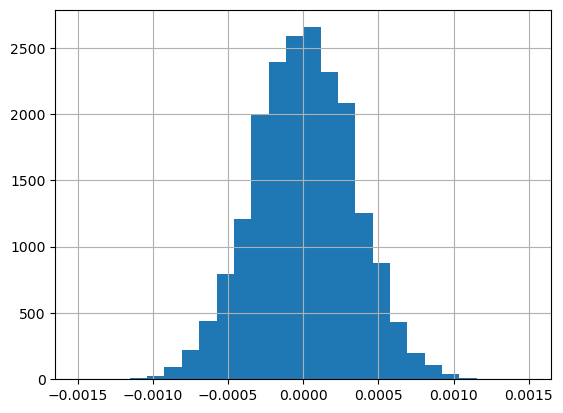

In [418]:
fig, ax = plt.subplots(1,1)
(antimu_reconstructed_P["P_y"] - simulated_events["py_mu2"]).hist(ax = ax, bins =np.linspace(-0.0015,0.0015,27))